In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib import cm, ticker
plt.rcParams.update({'font.size': 16})
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.family': 'serif'})

import networkx as nx

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from seaborn import clustermap, hls_palette

from sklearn.metrics import silhouette_score

from utils import distance
from utils import CommonFunctions as CF

from galib import models as HM

from scipy.linalg import eig

import seaborn as sns

import pandas as pd

In [2]:
def compute_corrmat(ress):
    ### Compute cophenetic correlation coefficient
    T = len(ress)

    corr_mat = np.zeros((T-1,T-1))

    for idx in range(T):
        z1 = ress[idx][2]
        dist1 = cophenet(z1)
    
        for idy in range(idx+1,T):
            z2 = ress[idy][2]
            dist2 = cophenet(z2)
        
            #print(idx,idy)
            corr_mat[idx,idy-1] = np.corrcoef(dist1, dist2)[0,1]

    corr_mat[np.tril_indices(T-1,-1)] = np.nan
    #corr_mat += corr_mat.T

    return (corr_mat)

# Goodness of clustering

In [442]:
N = 128

HMshape = [2,2,32]
avklist = [1,4,20]

#HMshape = [4,2,16]
#avklist = [2,4,12]

adj = HM.HMRandomGraph(HMshape, avklist)

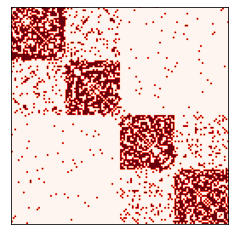

In [443]:
plt.imshow(adj, cmap='Reds')
plt.xticks([])
plt.yticks([])
plt.show()

In [444]:
dynamics = ['NoisyVM', 'Population', 'Epidemics', 'Epidemics', 'Biochemical', 'Mutualistic', 'Neuronal', 'Synchronization', 'Regulatory', 'Regulatory']
params = [[1, 1], [1, 1, 2, 1], [1,1], [1, 0.05], [1, 1, 1], [1, 1, 1], [1, 1, 1], [0, 1], [1, 1, 1, 1], [1, 1, 2, 1]]
params_to_print = ['', ' b=2', ' R=1', ' R=0.05', '']
labels_short = ['NVM', 'Pop$_{b=2}$', r'Epi$_{R=1}$', r'Epi$_{R=0.05}$', 'Bio', 'Mut', 'Neu', 'Syn', r'Reg$_{a=1}$', r'Reg$_{a=2}$']

JACOBIAN DISTANCE
Dynamics: NoisyVM
[1, 1]


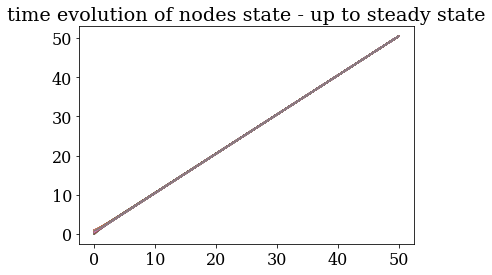

[1, 1]
Normalizing jacobian - $\lambda_{max}$=1.2951662411618812
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Population
[1, 1, 2, 1]


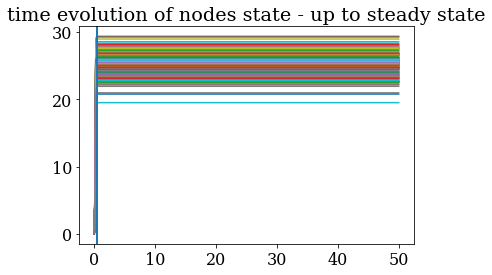

[1, 1, 2, 1]
Normalizing jacobian - $\lambda_{max}$=61.505577303011336
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 1]


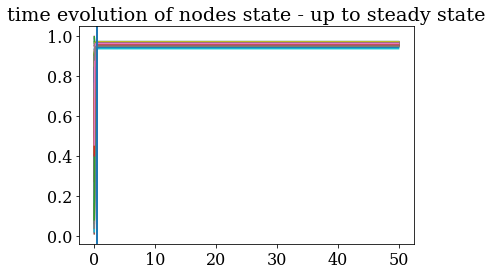

[1, 1]
Normalizing jacobian - $\lambda_{max}$=33.63497242317856
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.05]


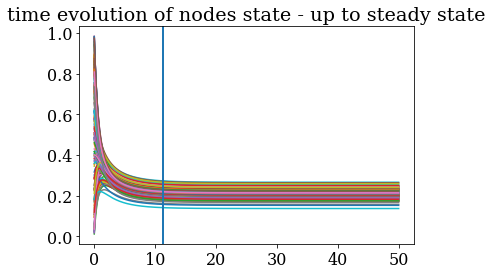

[1, 0.05]
Normalizing jacobian - $\lambda_{max}$=1.5674695269562495
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Biochemical
[1, 1, 1]


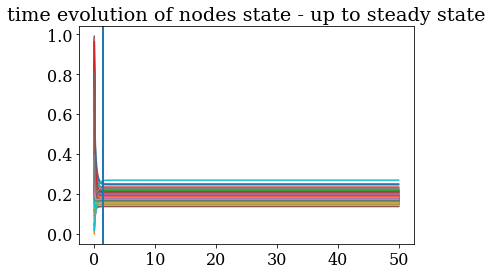

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=10.27900222033436
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Mutualistic
[1, 1, 1]


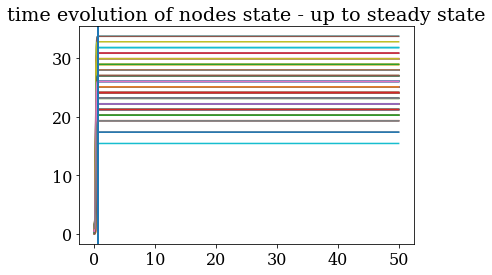

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=33.69031493771729
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 1, 1]


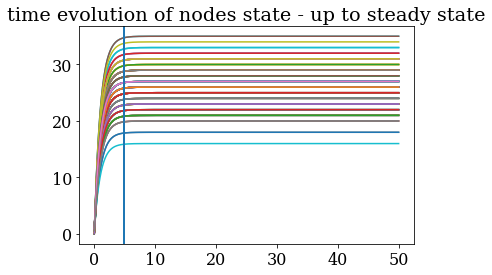

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=1.0000000000000013
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Synchronization
[0, 1]


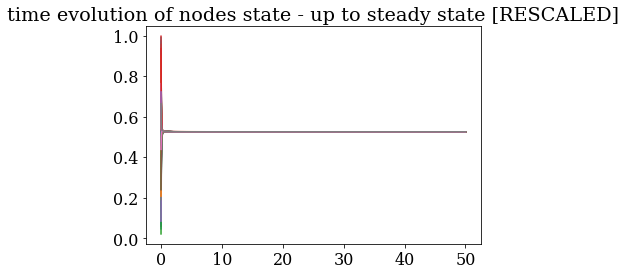

[0, 1]
Normalizing jacobian - $\lambda_{max}$=36.7779346645202
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Regulatory
[1, 1, 1, 1]


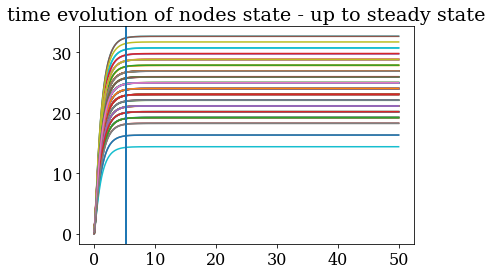

[1, 1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=1.012324541708357
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Regulatory
[1, 1, 2, 1]


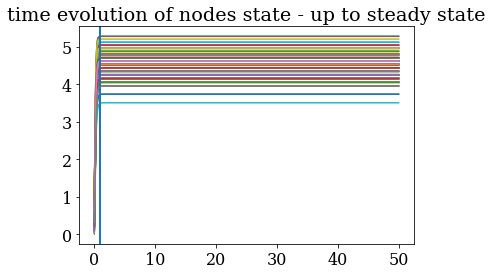

[1, 1, 2, 1]
Normalizing jacobian - $\lambda_{max}$=10.574515059591603
- Compute average distance...



- Compute hierarchical clustering with method ward...


In [445]:
ress = []

for i, dynamic in enumerate(dynamics):
    res = distance.jacobian_distance(adj, dynamic, norm=True, args=params[i], name='fig3', title=None, comms=None, show=False)
    ress.append(res)

### Silhouette score

In [440]:
ncomms = np.arange(2,N)


for res in ress:
    mat_to_clust = res[0]

    ### Compute dendrogram
    mylinkage = linkage(squareform(mat_to_clust), method='average')
    ### Compute communities = cut dendrogram
    comms = [fcluster(mylinkage, criterion='maxclust', t=t) for t in ncomms]

    ### Compute silhouette coefficient
    sil = []

    for comm in comms:
        tmp = silhouette_score(mat_to_clust, comm, metric="precomputed")
        sil.append(tmp)

    ### Plot sil
    plt.plot(sil)
    plt.show()

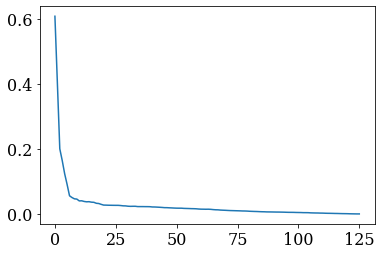

In [364]:
plt.plot(sil)
plt.show()

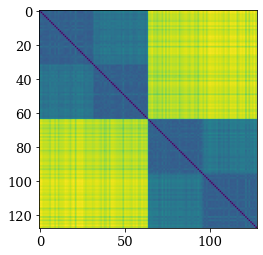

In [66]:
plt.imshow(ress[0][0])

In [3]:
def cluster_distance(distance, comms):
    #distance = distance**2
    comms_id = np.unique(comms)
    n_comms = len(comms_id)
    avg_with_cluster = np.zeros(n_comms)
    avg_btw_cluster = np.zeros(n_comms)
    
    for ii, idx in enumerate(comms_id):
        mask = comms==idx
        
        mask_with = mask[:,None] * mask
        mask_btw = mask[:,None] * np.logical_not(mask)
        np.fill_diagonal(mask_with, False)
        
        #avg_dd_cluster[ii] = np.sum(distance[mask]) / 2
        avg_with_cluster[ii] = np.mean(distance[mask_with])
        avg_btw_cluster[ii] = np.mean(distance[mask_btw])
        
    return avg_with_cluster, avg_btw_cluster

In [102]:
ws, bs = [], []
ws_fake, bs_fake = [], []

for idx, tmp_comm in enumerate(comms):
    print(len(np.unique(tmp_comm)))
    random_tmp_comm = tmp_comm.copy()
    np.random.shuffle(random_tmp_comm)
    
    real_w, real_b = cluster_distance(ress[0][0], tmp_comm)
    fake_w, fake_b = cluster_distance(ress[0][0], random_tmp_comm)
    
    ws.append(real_w.mean())
    bs.append(real_b.mean())
    ws_fake.append(fake_w.mean())
    bs_fake.append(fake_b.mean())
    
    print(real_w.mean(), real_b.mean(), fake_w.mean(), fake_b.mean())

2
0.011705740566466546 0.03004142421315055 0.020958672836929572 0.020933069009413503
3
0.010786046571609349 0.026299545624346044 0.02079141292208896 0.020967711587522263
4
0.010340595267757833 0.02437035783363057 0.02099274700085747 0.020930600503150477
5
0.010220440758453554 0.023566940884358647 0.02087906376183264 0.020949157627330885
6
0.010100326696722768 0.02299080681421499 0.020233250270798427 0.020979457826187986
7
0.010012855268840012 0.022665263274539986 0.02125955859406992 0.0209000414571699
8
0.00995902312737453 0.022356361599821576 0.02047242516406485 0.021005088663563324
9
0.009912880808805879 0.02216302208690211 0.020866418528513883 0.020943293845510278


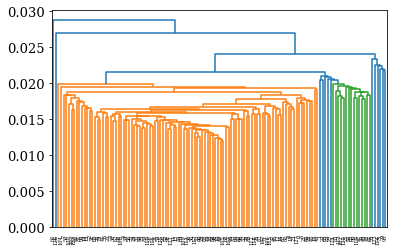

In [234]:
# Compute linkage
mylinkage = linkage(squareform(ress[4][0]), method='ward')
# Create dendrogram
dn = dendrogram(mylinkage, no_plot=False)
# Get heights
heights = np.array( [tmp[1] for tmp in dn['dcoord']] )
heights = np.sort(heights)[::-1]
deltas = heights[:-1] - heights[1:]
deltas = np.concatenate([deltas, [heights[-1]]])

In [238]:
heights[0], heights[1], heights[2]

(0.028807083483542984, 0.027016285035272057, 0.024010192163949458)

In [223]:
deltas[0], deltas[1], deltas[2], deltas[3]

(0.007222976390111428,
 0.00010066059834207622,
 0.003478606772764221,
 0.00045324655446776774)

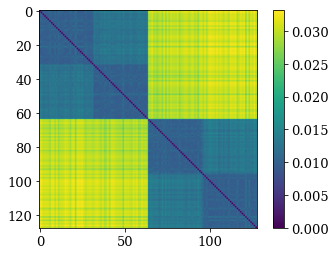

In [224]:
plt.imshow(ress[0][0])
plt.colorbar()
plt.show()

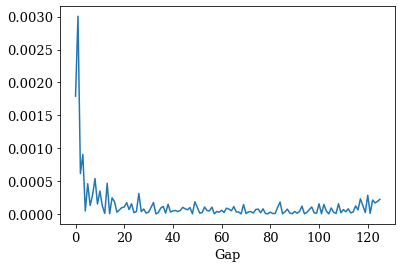

In [231]:
plt.plot(heights[:-1]-heights[1:])
plt.xlabel('Gap')
plt.ylabel('')
plt.show()

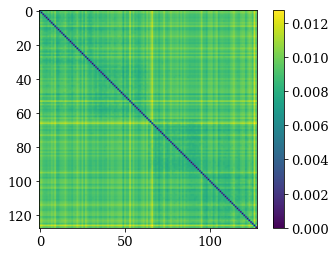

In [226]:
plt.imshow(ress[1][0])
plt.colorbar()
plt.show()

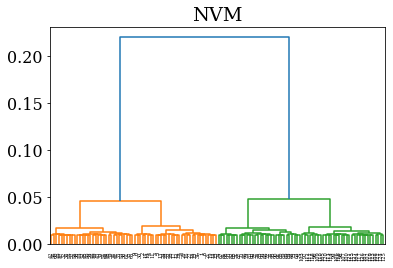

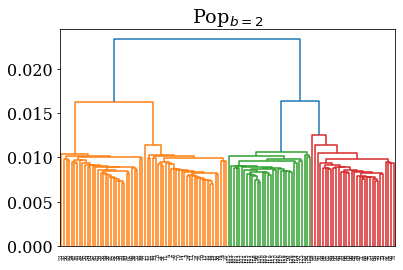

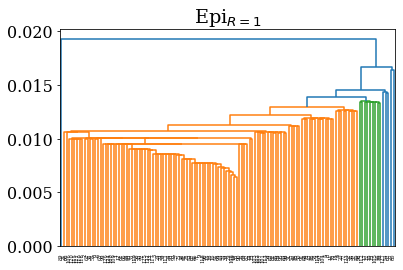

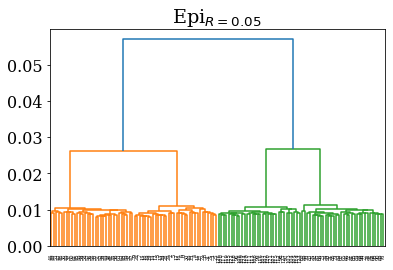

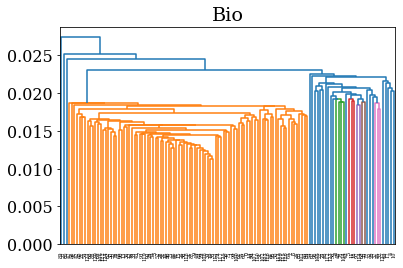

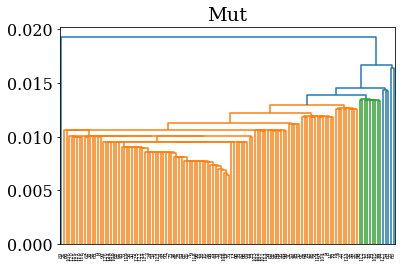

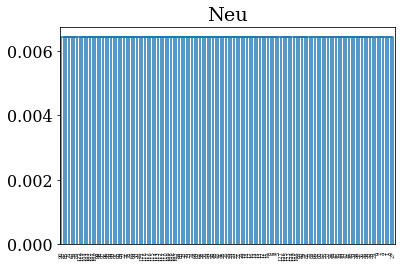

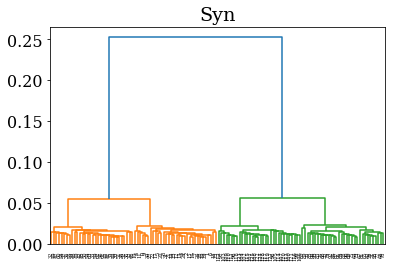

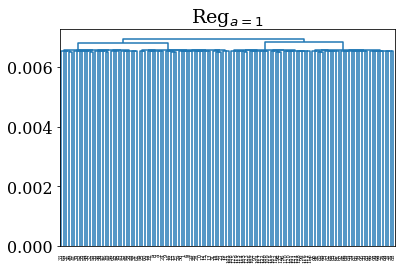

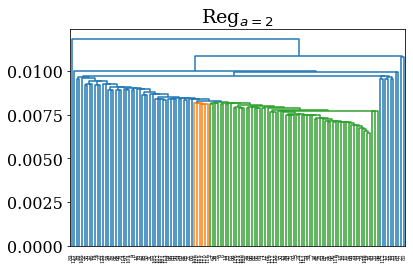

In [449]:
to_plot = True

deltas_all = []

for idx, res in enumerate(ress):
    # Compute linkage
    mylinkage = linkage(squareform(res[0]), method='ward')
    # Create dendrogram
    dn = dendrogram(mylinkage, no_plot=not to_plot)
    plt.title(labels_short[idx])
    plt.show()
    # Get heights
    heights = np.array( [tmp[1] for tmp in dn['dcoord']] )
    heights = np.sort(heights)[::-1]
    #print(heights)
    deltas = heights[:-1] - heights[1:]
    deltas = np.concatenate([deltas, [heights[-1]]])
    
    deltas_all.append(deltas)

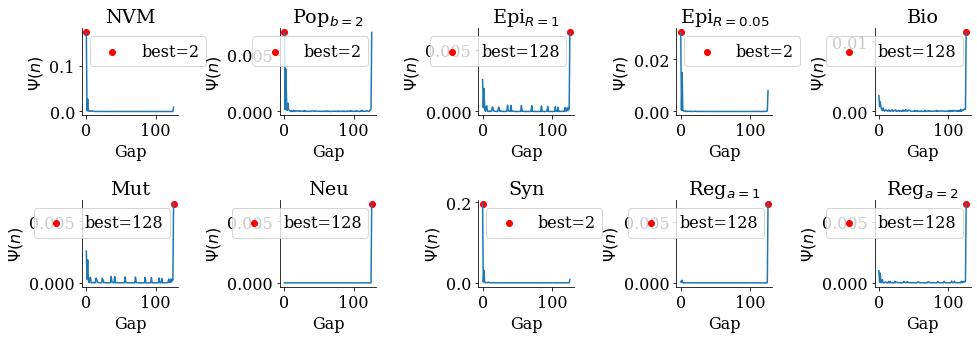

In [450]:
plt.figure(figsize=(14,5))

n_rows = 2
n_cols = 5

for idx, dynamic in enumerate(labels_short):
    plt.subplot(n_rows,n_cols, idx+1)
    
    plt.plot(deltas_all[idx])
    #plt.plot(np.log(heights_all[idx][:-1]) - np.log(heights_all[idx][1:]))
    plt.title(dynamic)
    plt.xlabel('Gap')
    plt.ylabel(r'$\Psi(n)$')
    
    best_gap = np.argmax(deltas_all[idx])
    plt.scatter(best_gap, np.max(deltas_all[idx]), c='r', label='best='+str(best_gap+2))
    plt.legend()
    
sns.despine()
plt.tight_layout()
plt.show()

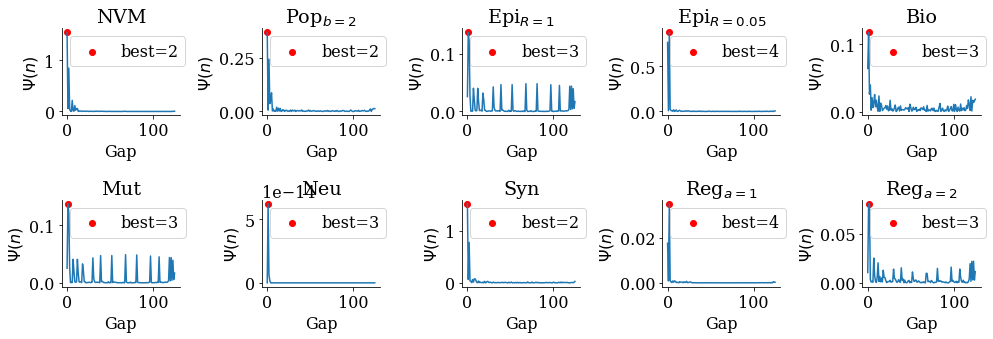

In [451]:
plt.figure(figsize=(14,5))

n_rows = 2
n_cols = 5

for idx, dynamic in enumerate(labels_short):
    plt.subplot(n_rows,n_cols, idx+1)
    
    tmp = np.log(heights_all[idx][:-1]) - np.log(heights_all[idx][1:])
    #plt.plot(deltas_all[idx])
    plt.plot(tmp)
    plt.title(dynamic)
    plt.xlabel('Gap')
    plt.ylabel(r'$\Psi(n)$')
    
    best_gap = np.argmax(tmp)
    plt.scatter(best_gap, np.max(tmp), c='r', label='best='+str(best_gap+2))
    plt.legend()
    
sns.despine()
plt.tight_layout()
plt.show()

# Varying coupling parameters

### Epidemics

JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.05]


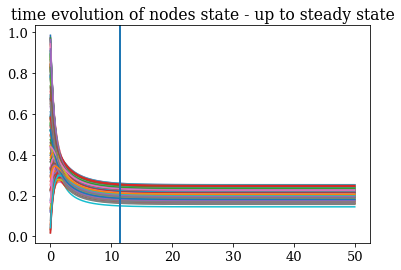

[1, 0.05]
Normalizing jacobian - $\lambda_{max}$=1.5625465298624992
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.060000000000000005]


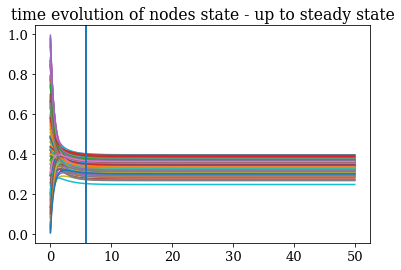

[1, 0.060000000000000005]
Normalizing jacobian - $\lambda_{max}$=1.830483632054771
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.07]


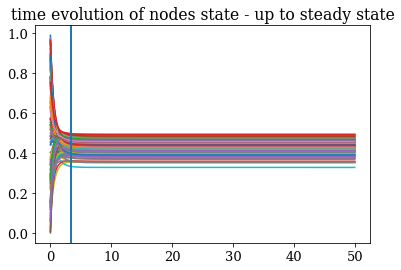

[1, 0.07]
Normalizing jacobian - $\lambda_{max}$=2.1125746777188947
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.08000000000000002]


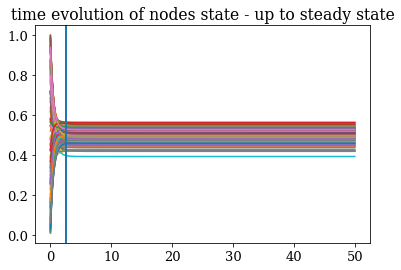

[1, 0.08000000000000002]
Normalizing jacobian - $\lambda_{max}$=2.4070539542887044
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.09000000000000001]


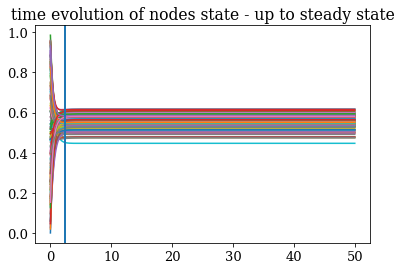

[1, 0.09000000000000001]
Normalizing jacobian - $\lambda_{max}$=2.710160317609061
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.1]


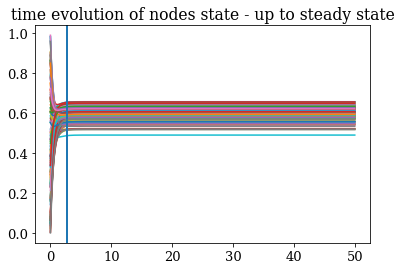

[1, 0.1]
Normalizing jacobian - $\lambda_{max}$=3.0182658177475155
- Compute average distance...



- Compute hierarchical clustering with method ward...


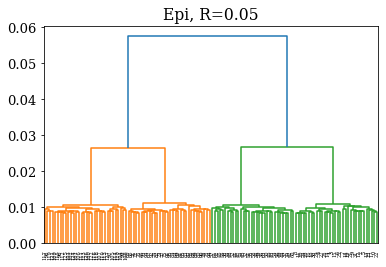

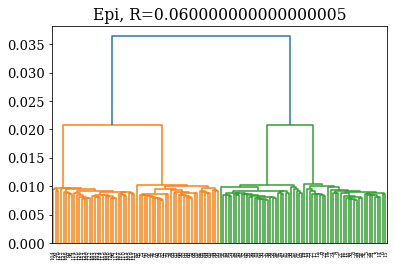

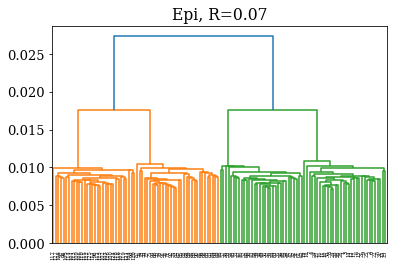

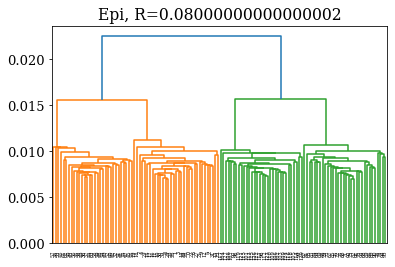

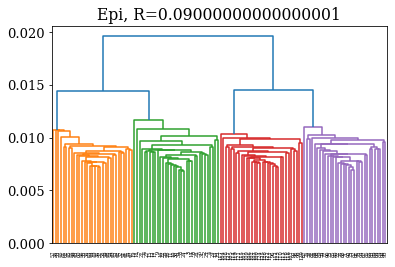

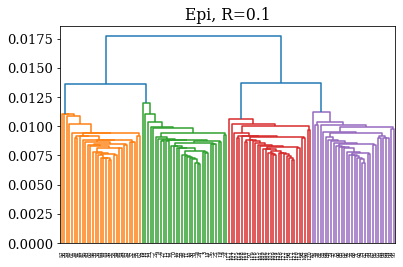

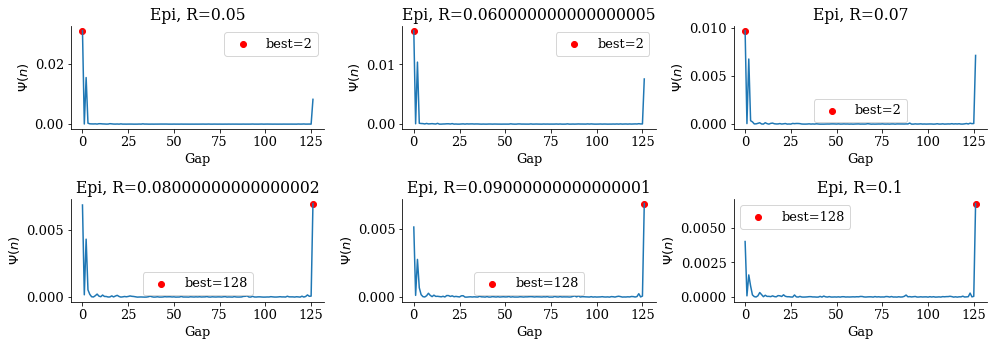

In [340]:
dynamic = 'Epidemics'

B = 1
Rs = np.arange(0.05, 0.11, 0.01)

params = [[B, R] for R in Rs]
params_to_print = [f'R={R}' for R in Rs]
labels_short = [f'Epi, R={R}' for R in Rs]
params

### Compute Jac distance
ress = []

for i, param in enumerate(params):
    res = distance.jacobian_distance(adj, dynamic, norm=True, args=param, name=None, title=None, comms=None, show=False)
    ress.append(res)

### Compute deltas
to_plot = True

deltas_all = []

for idx, res in enumerate(ress):
    # Compute linkage
    mylinkage = linkage(squareform(res[0]), method='ward')
    # Create dendrogram
    dn = dendrogram(mylinkage, no_plot=not to_plot)
    plt.title(labels_short[idx])
    plt.show()
    # Get heights
    heights = np.array( [tmp[1] for tmp in dn['dcoord']] )
    heights = np.sort(heights)[::-1]
    deltas = heights[:-1] - heights[1:]
    deltas = np.concatenate([deltas, [heights[-1]]])
    
    deltas_all.append(deltas)
    
### Plot deltas
plt.figure(figsize=(14,5))

n_rows = 2
n_cols = len(ress) // n_rows

for idx, dynamic in enumerate(labels_short):
    plt.subplot(n_rows,n_cols, idx+1)
    
    plt.plot(deltas_all[idx])
    #plt.plot(np.log(heights_all[idx][:-1]) - np.log(heights_all[idx][1:]))
    plt.title(dynamic)
    plt.xlabel('Gap')
    plt.ylabel(r'$\Psi(n)$')
    
    best_gap = np.argmax(deltas_all[idx])
    plt.scatter(best_gap, np.max(deltas_all[idx]), c='r', label='best='+str(best_gap+2))
    plt.legend()
    
sns.despine()
plt.tight_layout()
plt.show()

### Neuronal

JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 0.01, 0.01]


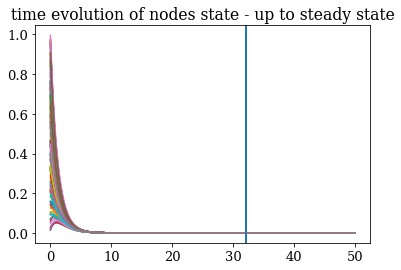

[1, 0.01, 0.01]
Normalizing jacobian - $\lambda_{max}$=1.0638321754782512
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 0.01, 0.015]


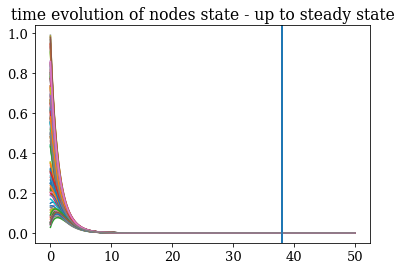

[1, 0.01, 0.015]
Normalizing jacobian - $\lambda_{max}$=1.1007482632173933
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 0.01, 0.019999999999999997]


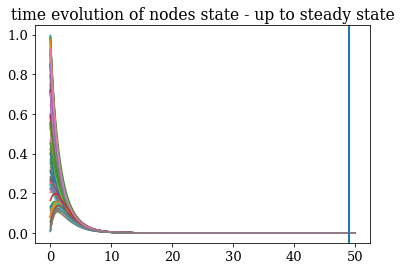

[1, 0.01, 0.019999999999999997]
Normalizing jacobian - $\lambda_{max}$=1.1376643509565274
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 0.01, 0.024999999999999998]


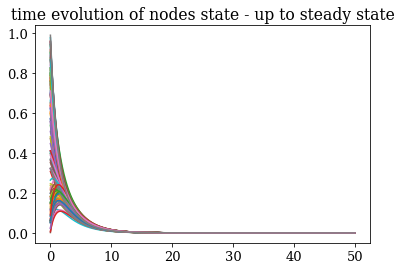

[1, 0.01, 0.024999999999999998]
Normalizing jacobian - $\lambda_{max}$=1.1745804386956515
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 0.01, 0.03]


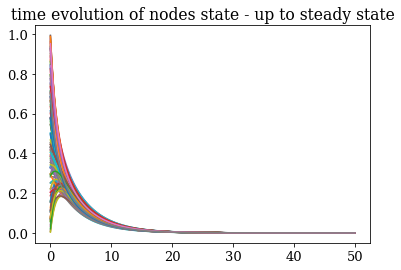

[1, 0.01, 0.03]
Normalizing jacobian - $\lambda_{max}$=1.2114965264286985
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 0.01, 0.034999999999999996]


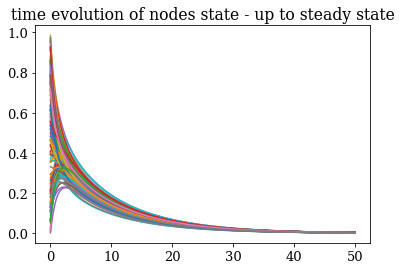

[1, 0.01, 0.034999999999999996]
Normalizing jacobian - $\lambda_{max}$=1.2484108333762927
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 0.01, 0.039999999999999994]


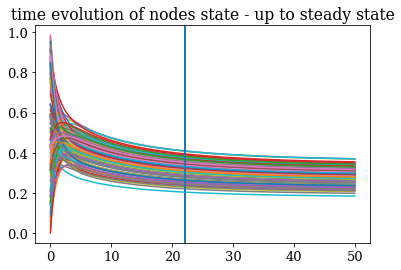

[1, 0.01, 0.039999999999999994]
Normalizing jacobian - $\lambda_{max}$=1.2627548682276815
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 0.01, 0.045]


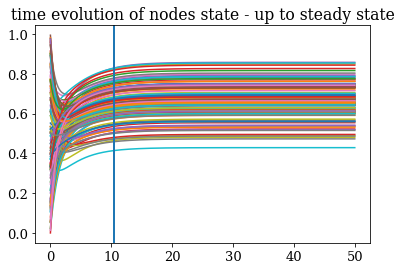

[1, 0.01, 0.045]
Normalizing jacobian - $\lambda_{max}$=1.2141657182776842
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 0.01, 0.049999999999999996]


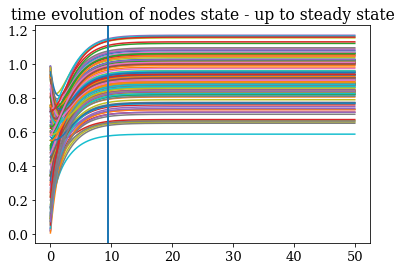

[1, 0.01, 0.049999999999999996]
Normalizing jacobian - $\lambda_{max}$=1.1764737830375518
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 0.01, 0.05499999999999999]


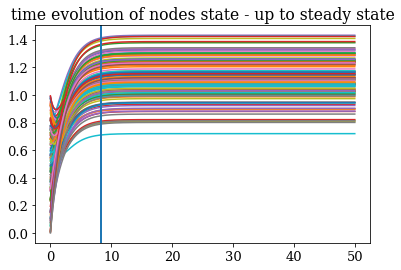

[1, 0.01, 0.05499999999999999]
Normalizing jacobian - $\lambda_{max}$=1.1466105025205087
- Compute average distance...



- Compute hierarchical clustering with method ward...


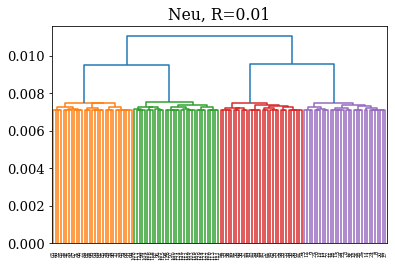

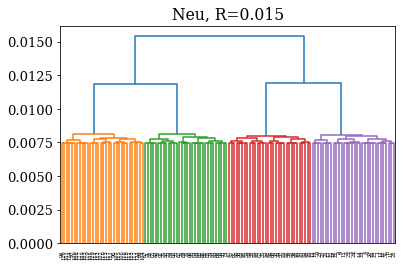

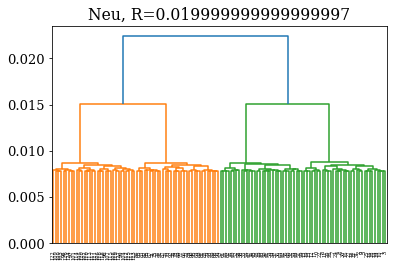

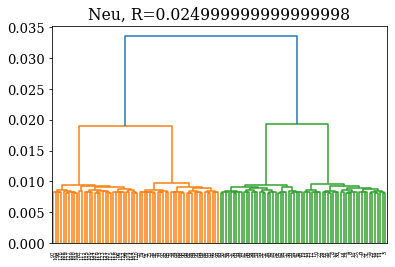

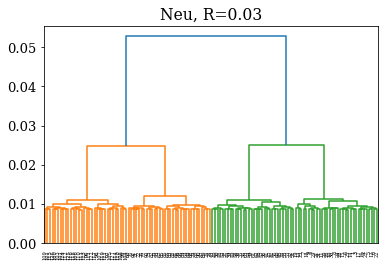

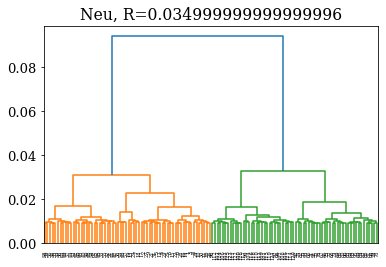

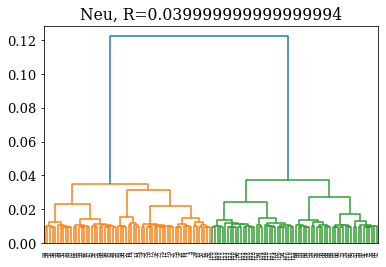

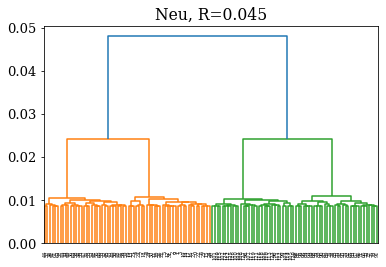

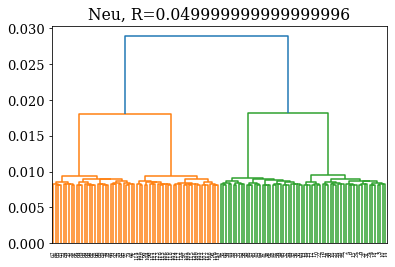

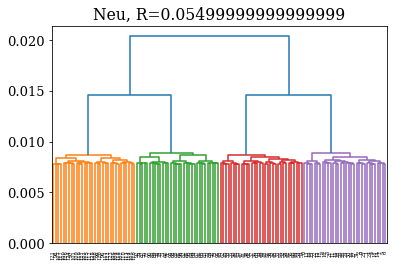

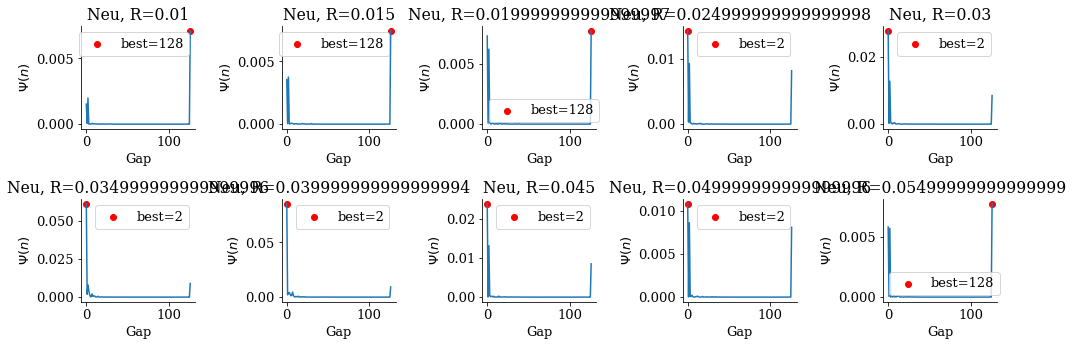

In [348]:
dynamic = 'Neuronal'

B = 1
C = 0.01
Rs = np.arange(0.01, 0.06, 0.005) #[0.01, 0.02, 0.03, 0.04, 0.05] #np.arange(0.1, 1., 0.2)

params = [[B, C, R] for R in Rs]
params_to_print = [f'R={R}' for R in Rs]
labels_short = [f'Neu, R={R}' for R in Rs]
params

### Compute Jac distance
ress = []

for i, param in enumerate(params):
    res = distance.jacobian_distance(adj, dynamic, norm=True, args=param, name=None, title=None, comms=None, show=False)
    ress.append(res)

### Compute deltas
to_plot = True

deltas_all = []

for idx, res in enumerate(ress):
    # Compute linkage
    mylinkage = linkage(squareform(res[0]), method='ward')
    # Create dendrogram
    dn = dendrogram(mylinkage, no_plot=not to_plot)
    plt.title(labels_short[idx])
    plt.show()
    # Get heights
    heights = np.array( [tmp[1] for tmp in dn['dcoord']] )
    heights = np.sort(heights)[::-1]
    deltas = heights[:-1] - heights[1:]
    deltas = np.concatenate([deltas, [heights[-1]]])
    
    deltas_all.append(deltas)
    
### Plot deltas
plt.figure(figsize=(14,5))

n_rows = 2
n_cols = len(ress) // n_rows

for idx, dynamic in enumerate(labels_short):
    plt.subplot(n_rows,n_cols, idx+1)
    
    plt.plot(deltas_all[idx])
    #plt.plot(np.log(heights_all[idx][:-1]) - np.log(heights_all[idx][1:]))
    plt.title(dynamic)
    plt.xlabel('Gap')
    plt.ylabel(r'$\Psi(n)$')
    
    best_gap = np.argmax(deltas_all[idx])
    plt.scatter(best_gap, np.max(deltas_all[idx]), c='r', label='best='+str(best_gap+2))
    plt.legend()
    
sns.despine()
plt.tight_layout()
plt.show()

### Biochemical

JACOBIAN DISTANCE
Dynamics: Biochemical
[1, 1, 0.05]


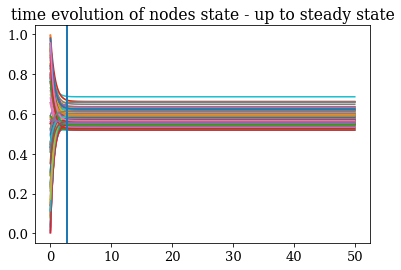

[1, 1, 0.05]
Normalizing jacobian - $\lambda_{max}$=2.4851163885603245
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Biochemical
[1, 1, 0.060000000000000005]


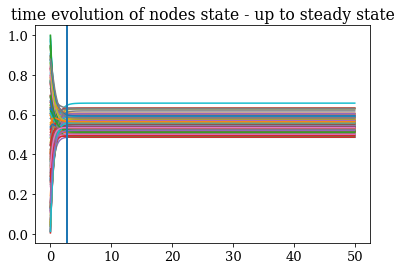

[1, 1, 0.060000000000000005]
Normalizing jacobian - $\lambda_{max}$=2.685434405280249
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Biochemical
[1, 1, 0.07]


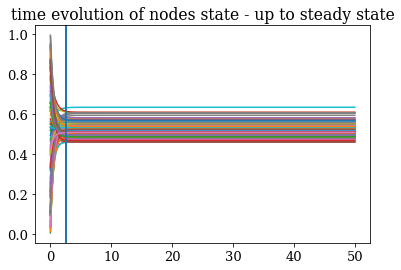

[1, 1, 0.07]
Normalizing jacobian - $\lambda_{max}$=2.871834898314302
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Biochemical
[1, 1, 0.08000000000000002]


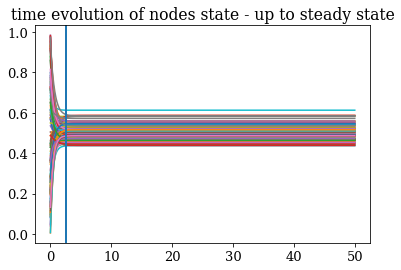

[1, 1, 0.08000000000000002]
Normalizing jacobian - $\lambda_{max}$=3.0468705789924764
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Biochemical
[1, 1, 0.09000000000000001]


KeyboardInterrupt: 

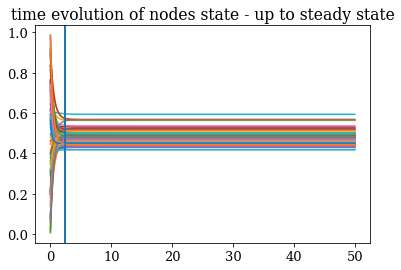

In [342]:
dynamic = 'Biochemical'

F = 1
B = 1
Rs = np.arange(0.05, 0.11, 0.01)

params = [[F, B, R] for R in Rs]
params_to_print = [f'R={R}' for R in Rs]
labels_short = [f'Bio, R={R}' for R in Rs]
params

### Compute Jac distance
ress = []

for i, param in enumerate(params):
    res = distance.jacobian_distance(adj, dynamic, norm=True, args=param, name=None, title=None, comms=None, show=False)
    ress.append(res)

### Compute deltas
to_plot = True

deltas_all = []

for idx, res in enumerate(ress):
    # Compute linkage
    mylinkage = linkage(squareform(res[0]), method='ward')
    # Create dendrogram
    dn = dendrogram(mylinkage, no_plot=not to_plot)
    plt.title(labels_short[idx])
    plt.show()
    # Get heights
    heights = np.array( [tmp[1] for tmp in dn['dcoord']] )
    heights = np.sort(heights)[::-1]
    deltas = heights[:-1] - heights[1:]
    deltas = np.concatenate([deltas, [heights[-1]]])
    
    deltas_all.append(deltas)
    
### Plot deltas
plt.figure(figsize=(14,5))

n_rows = 2
n_cols = len(ress) // n_rows

for idx, dynamic in enumerate(labels_short):
    plt.subplot(n_rows,n_cols, idx+1)
    
    plt.plot(deltas_all[idx])
    #plt.plot(np.log(heights_all[idx][:-1]) - np.log(heights_all[idx][1:]))
    plt.title(dynamic)
    plt.xlabel('Gap')
    plt.ylabel(r'$\Psi(n)$')
    
    best_gap = np.argmax(deltas_all[idx])
    plt.scatter(best_gap, np.max(deltas_all[idx]), c='r', label='best='+str(best_gap+2))
    plt.legend()
    
sns.despine()
plt.tight_layout()
plt.show()

# Exploring Structural Parameters

In [452]:
HMshape = [2,2,32]
avklist = [1,4,20]

adj = HM.HMRandomGraph(HMshape, avklist)

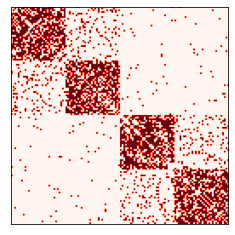

In [453]:
plt.imshow(adj, cmap='Reds')
plt.xticks([])
plt.yticks([])
plt.show()

In [454]:
# Remove intra-communities
adj[N//2:,:N//2] = 0
adj[:N//2,N//2:] = 0

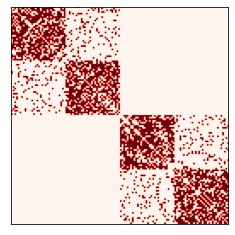

In [455]:
plt.imshow(adj, cmap='Reds')
plt.xticks([])
plt.yticks([])
plt.show()

JACOBIAN DISTANCE
Dynamics: NoisyVM
[1, 1]


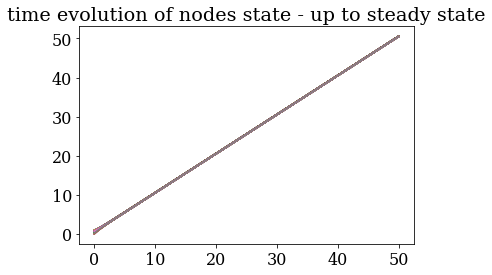

[1, 1]
Normalizing jacobian - $\lambda_{max}$=1.3006561011627102
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Population
[1, 1, 2, 1]


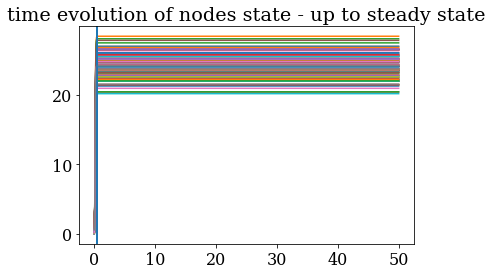

[1, 1, 2, 1]
Normalizing jacobian - $\lambda_{max}$=59.0924654376866
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 1]


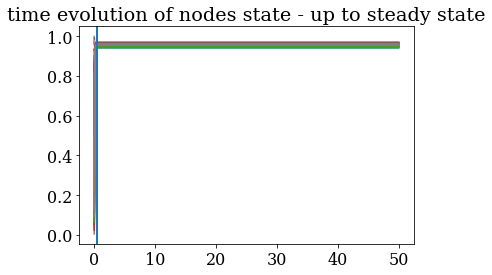

[1, 1]
Normalizing jacobian - $\lambda_{max}$=32.645377743077816
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.05]


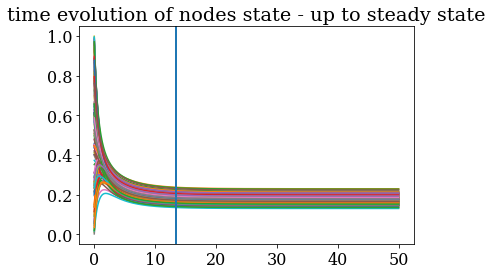

[1, 0.05]
Normalizing jacobian - $\lambda_{max}$=1.5098578736333452
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Biochemical
[1, 1, 1]


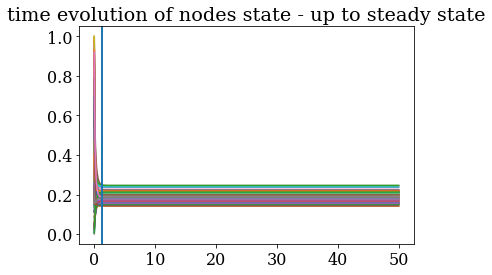

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=10.070751311325672
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Mutualistic
[1, 1, 1]


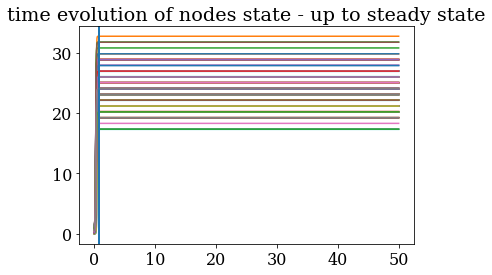

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=32.70132709102836
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 1, 1]


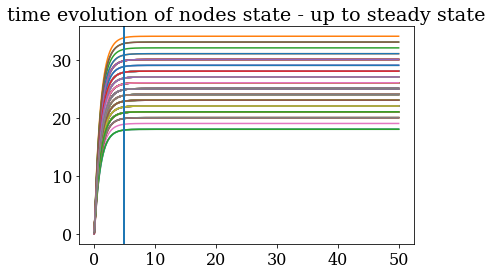

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=1.0000000000000009
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Synchronization
[0, 1]


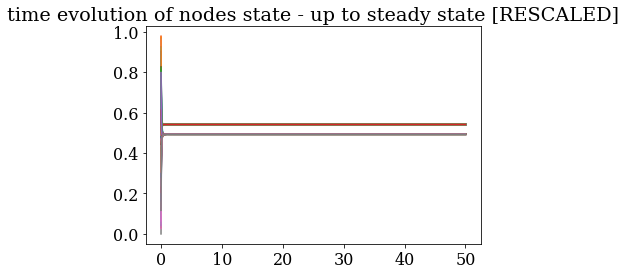

[0, 1]
Normalizing jacobian - $\lambda_{max}$=35.20988797156876
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Regulatory
[1, 1, 1, 1]


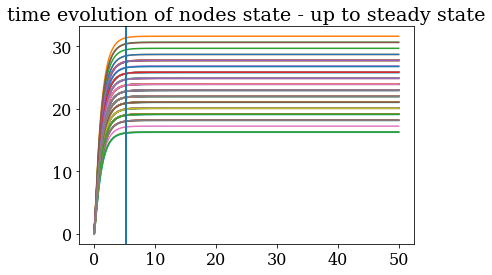

[1, 1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=1.013778557158822
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Regulatory
[1, 1, 2, 1]


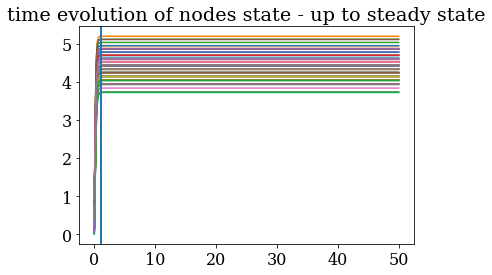

[1, 1, 2, 1]
Normalizing jacobian - $\lambda_{max}$=10.401907501673444
- Compute average distance...



- Compute hierarchical clustering with method ward...


In [456]:
ress = []

for i, dynamic in enumerate(dynamics):
    res = distance.jacobian_distance(adj, dynamic, norm=True, args=params[i], name='fig3', title=None, comms=None, show=False)
    ress.append(res)

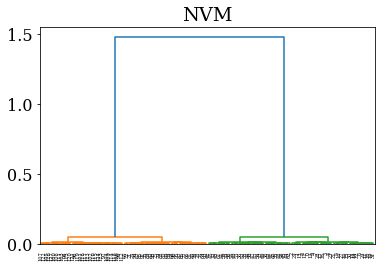

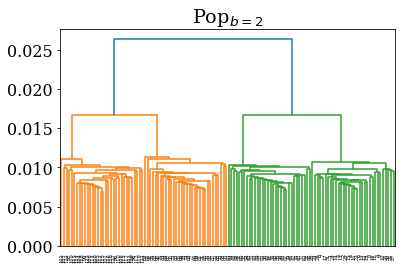

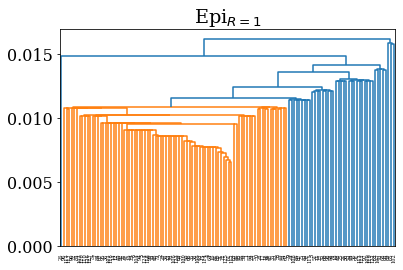

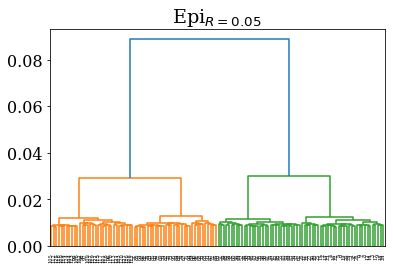

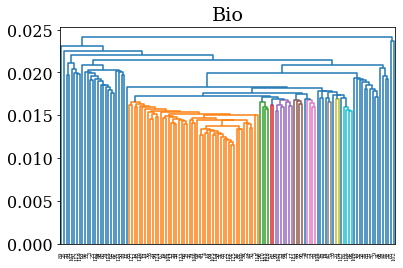

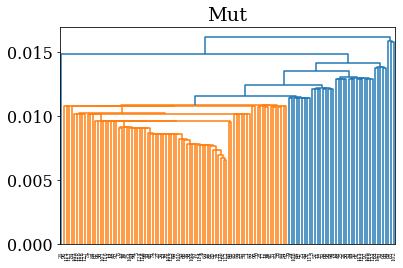

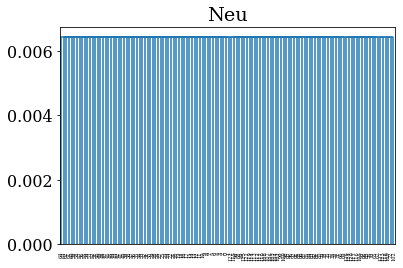

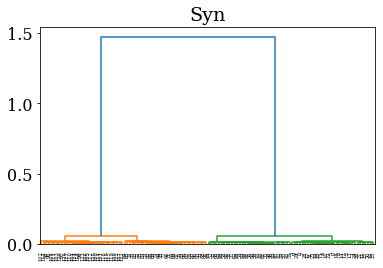

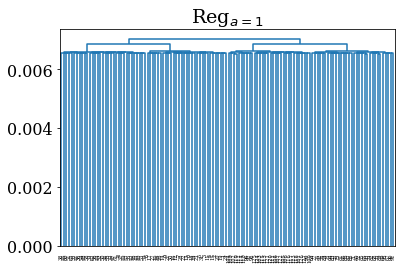

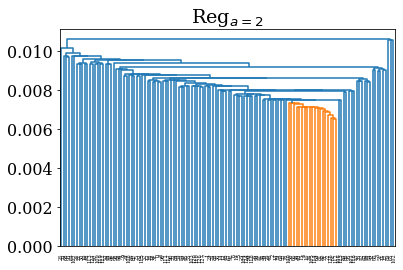

In [463]:
to_plot = True

deltas_all = []

for idx, res in enumerate(ress):
    # Compute linkage
    mylinkage = linkage(squareform(res[0]), method='ward')
    # Create dendrogram
    dn = dendrogram(mylinkage, no_plot=not to_plot)
    plt.title(labels_short[idx])
    plt.show()
    # Get heights
    heights = np.array( [tmp[1] for tmp in dn['dcoord']] )
    heights = np.sort(heights)[::-1]
    deltas = heights[:-1] - heights[1:]
    #deltas = deltas / deltas[0]
    deltas = np.concatenate([deltas, [heights[-1]]])
    
    deltas_all.append(deltas)

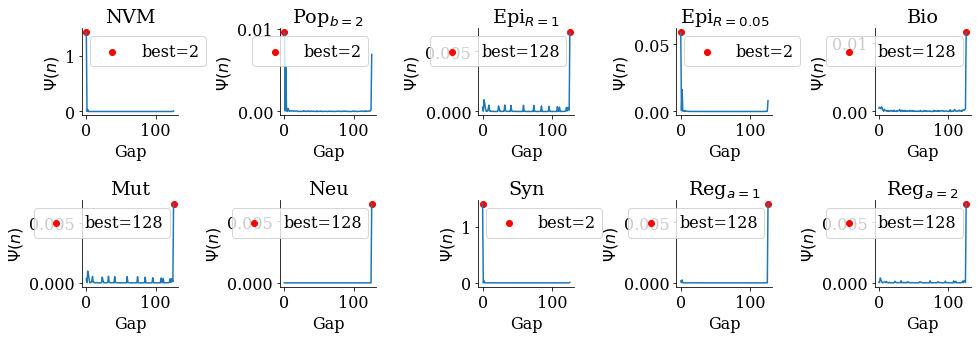

In [464]:
plt.figure(figsize=(14,5))

n_rows = 2
n_cols = 5

for idx, dynamic in enumerate(labels_short):
    plt.subplot(n_rows,n_cols, idx+1)
    
    plt.plot(deltas_all[idx])
    #plt.plot(np.log(heights_all[idx][:-1]) - np.log(heights_all[idx][1:]))
    plt.title(dynamic)
    plt.xlabel('Gap')
    plt.ylabel(r'$\Psi(n)$')
    
    best_gap = np.argmax(deltas_all[idx])
    plt.scatter(best_gap, np.max(deltas_all[idx]), c='r', label='best='+str(best_gap+2))
    plt.legend()
    
sns.despine()
plt.tight_layout()
plt.show()

# Slowly add links

In [470]:
ks = [5, 10, 15, 20]

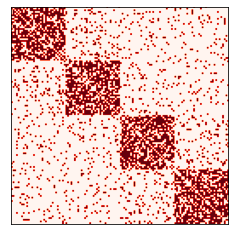

JACOBIAN DISTANCE
Dynamics: NoisyVM
[1, 1]


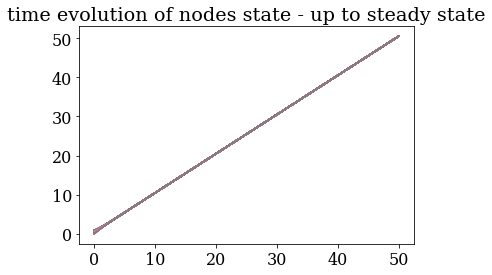

[1, 1]
Normalizing jacobian - $\lambda_{max}$=1.2709651814532215
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Population
[1, 1, 2, 1]


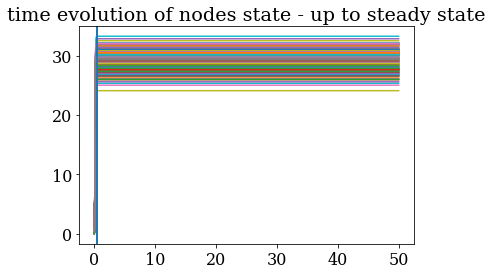

[1, 1, 2, 1]
Normalizing jacobian - $\lambda_{max}$=70.0139658105456
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 1]


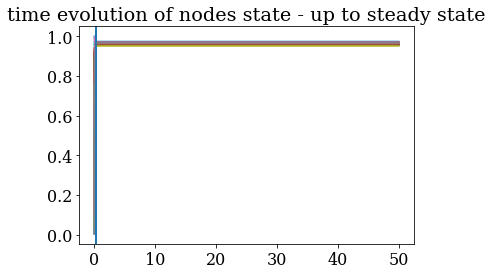

[1, 1]
Normalizing jacobian - $\lambda_{max}$=37.66689225162733
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.05]


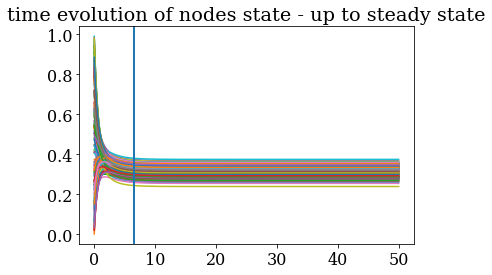

[1, 0.05]
Normalizing jacobian - $\lambda_{max}$=1.769747200495944
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Biochemical
[1, 1, 1]


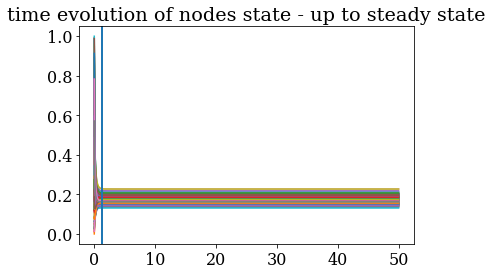

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=11.002424703808789
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Mutualistic
[1, 1, 1]


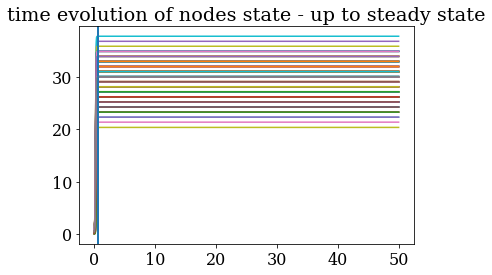

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=37.71403410868902
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 1, 1]


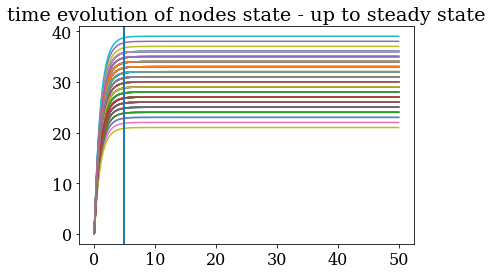

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=1.0000000000000016
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Synchronization
[0, 1]


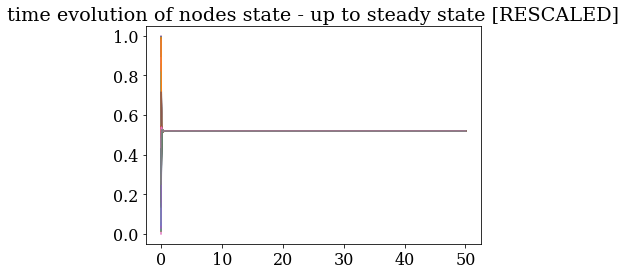

[0, 1]
Normalizing jacobian - $\lambda_{max}$=41.12728322589008
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Regulatory
[1, 1, 1, 1]


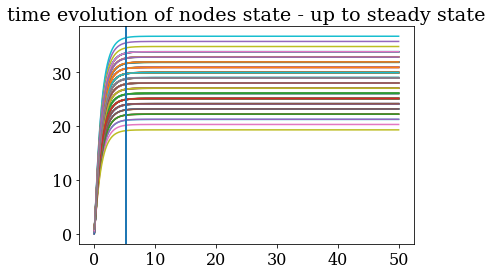

[1, 1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=1.0099107703458008
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Regulatory
[1, 1, 2, 1]


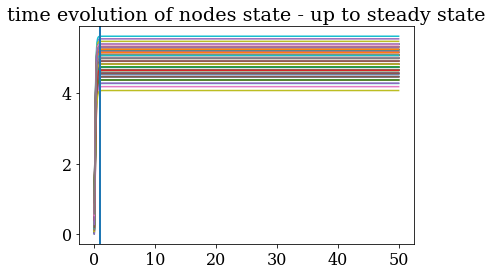

[1, 1, 2, 1]
Normalizing jacobian - $\lambda_{max}$=11.248568303640758
- Compute average distance...



- Compute hierarchical clustering with method ward...


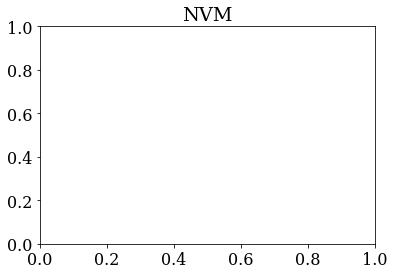

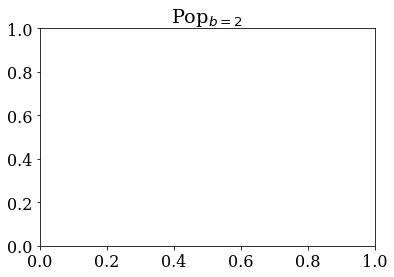

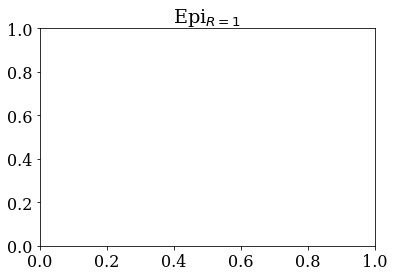

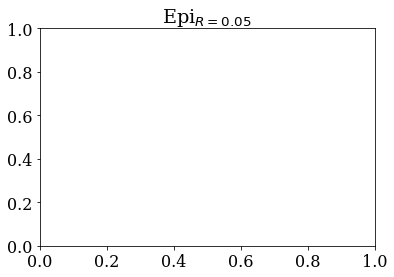

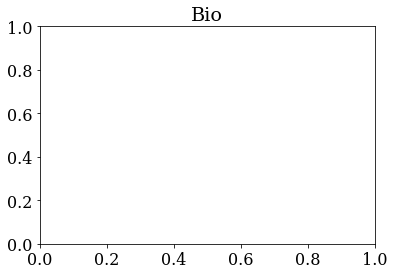

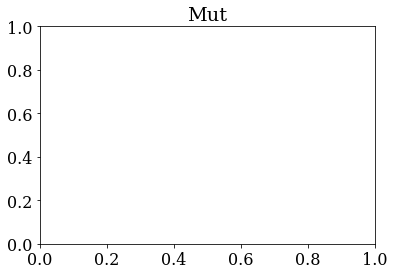

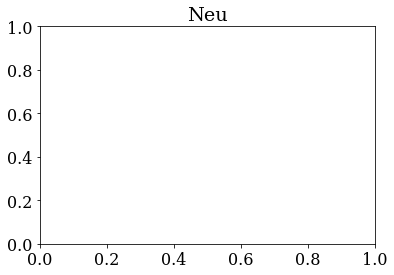

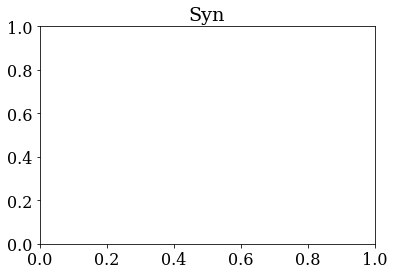

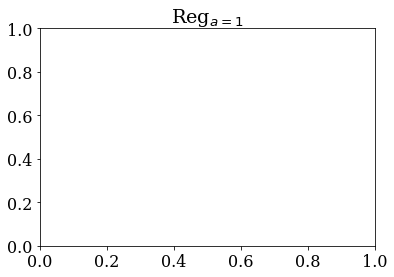

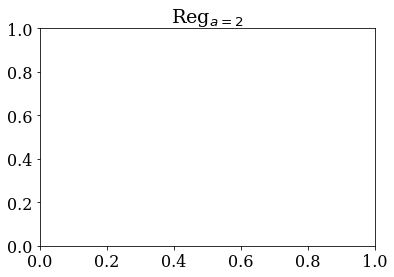

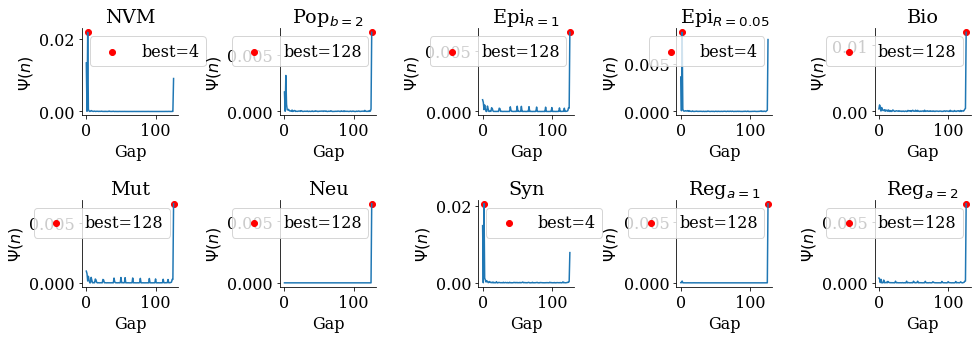

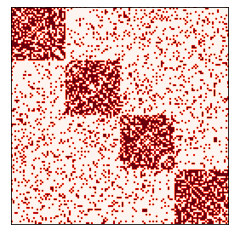

JACOBIAN DISTANCE
Dynamics: NoisyVM
[1, 1]


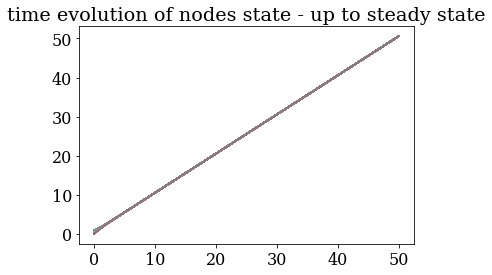

[1, 1]
Normalizing jacobian - $\lambda_{max}$=1.263378386698741
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Population
[1, 1, 2, 1]


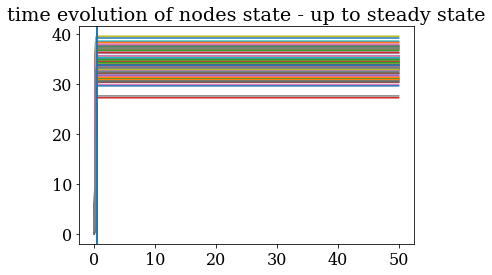

[1, 1, 2, 1]
Normalizing jacobian - $\lambda_{max}$=82.67868671340305
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 1]


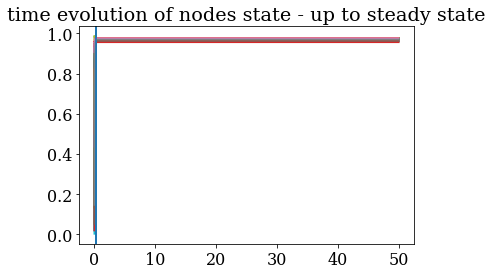

[1, 1]
Normalizing jacobian - $\lambda_{max}$=44.70453852214709
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.05]


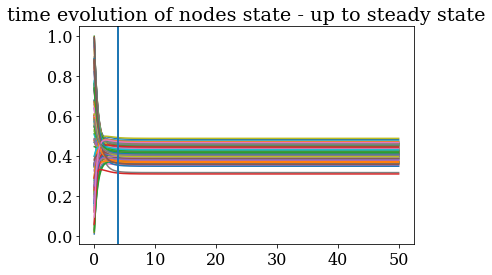

[1, 0.05]
Normalizing jacobian - $\lambda_{max}$=2.061184750401641
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Biochemical
[1, 1, 1]


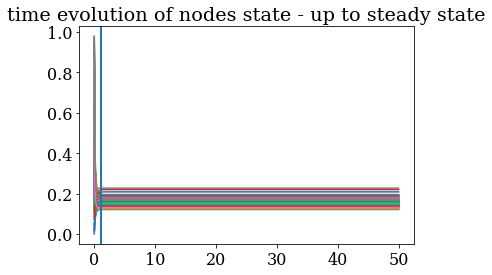

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=11.914358649443743
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Mutualistic
[1, 1, 1]


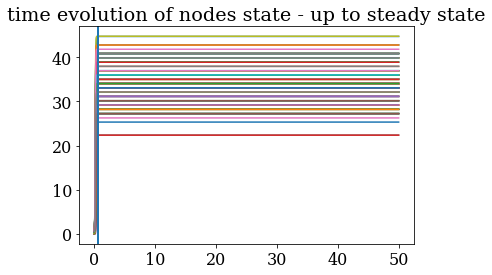

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=44.742199169833825
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 1, 1]


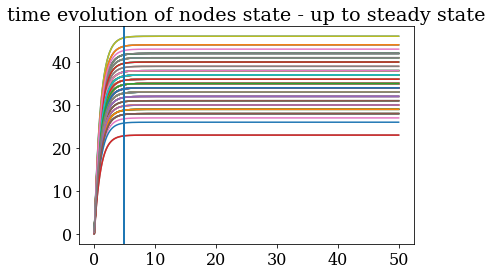

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=1.0000000000000016
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Synchronization
[0, 1]


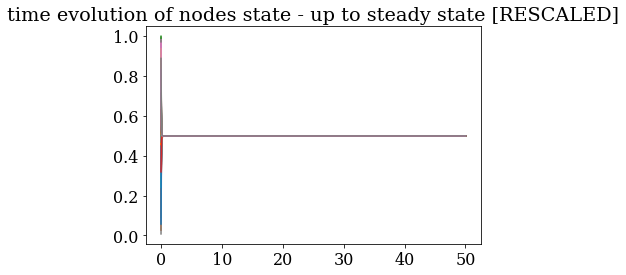

[0, 1]
Normalizing jacobian - $\lambda_{max}$=48.49801494841912
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Regulatory
[1, 1, 1, 1]


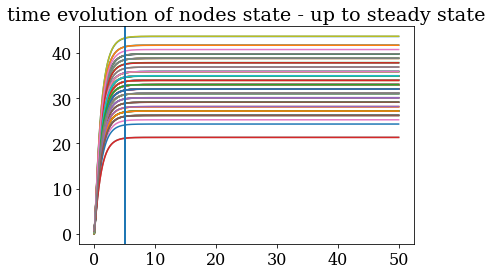

[1, 1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=1.0081509815450036
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Regulatory
[1, 1, 2, 1]


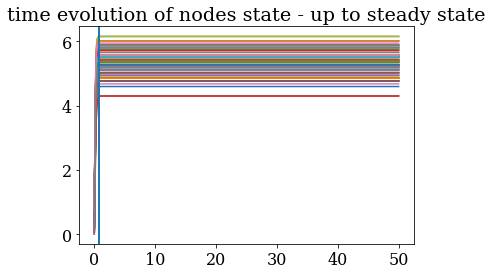

[1, 1, 2, 1]
Normalizing jacobian - $\lambda_{max}$=12.341974415423318
- Compute average distance...



- Compute hierarchical clustering with method ward...


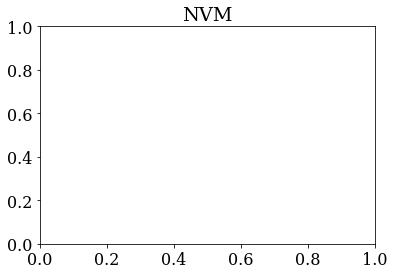

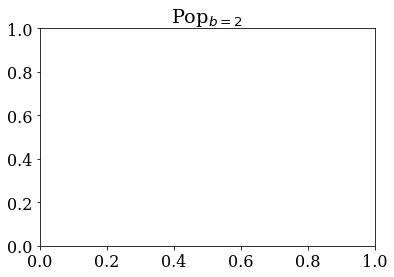

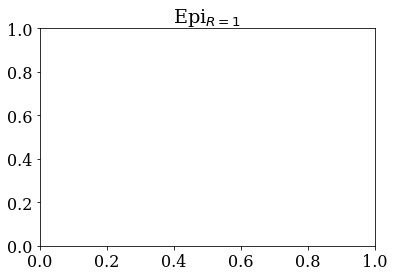

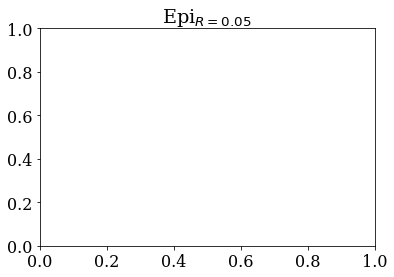

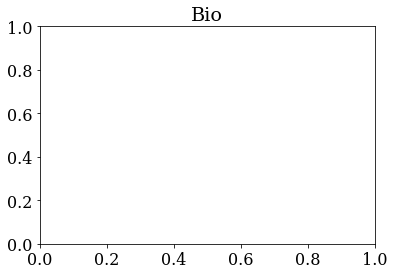

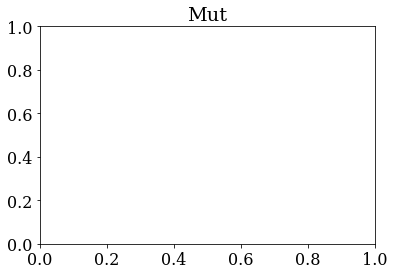

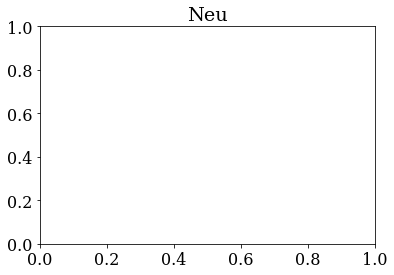

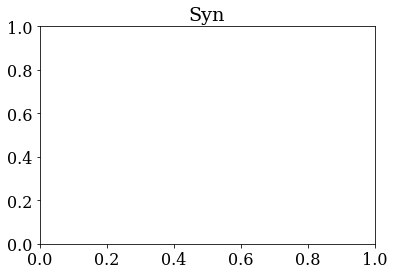

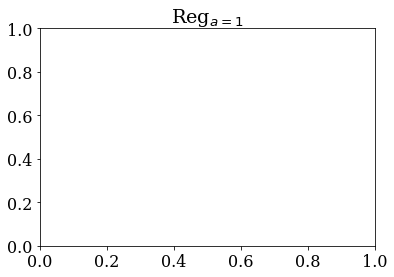

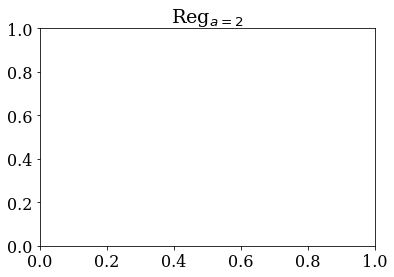

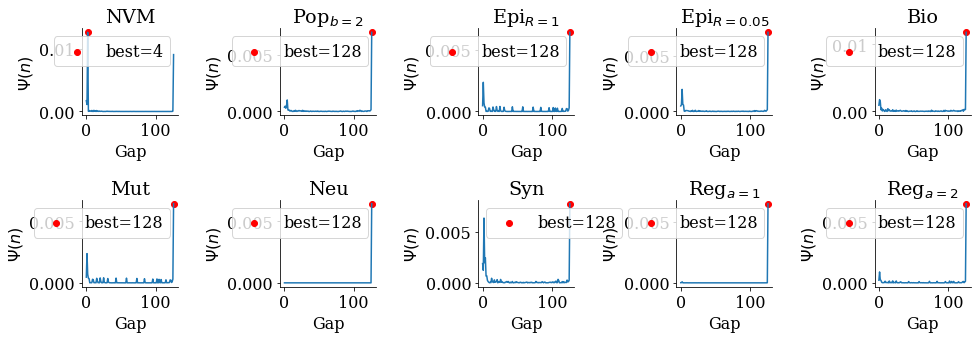

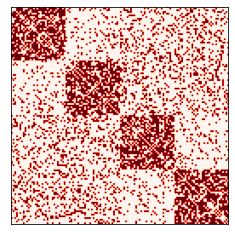

JACOBIAN DISTANCE
Dynamics: NoisyVM
[1, 1]


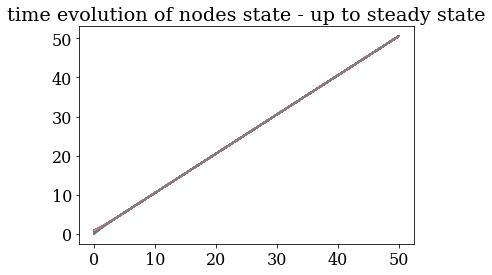

[1, 1]
Normalizing jacobian - $\lambda_{max}$=1.2505950653145548
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Population
[1, 1, 2, 1]


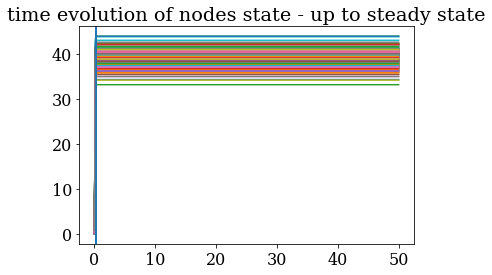

[1, 1, 2, 1]
Normalizing jacobian - $\lambda_{max}$=91.84551743642764
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 1]


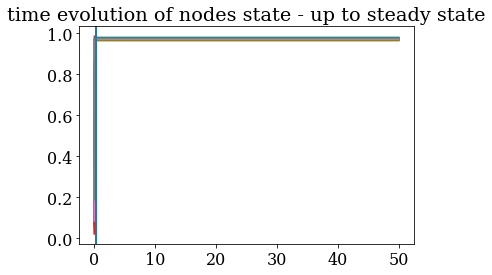

[1, 1]
Normalizing jacobian - $\lambda_{max}$=48.75343685025735
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.05]


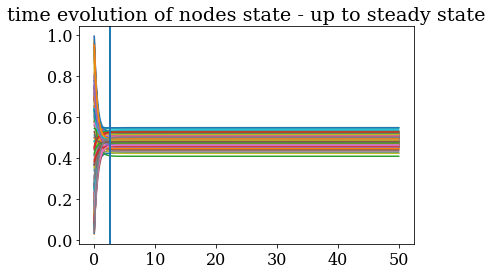

[1, 0.05]
Normalizing jacobian - $\lambda_{max}$=2.2941105097960786
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Biochemical
[1, 1, 1]


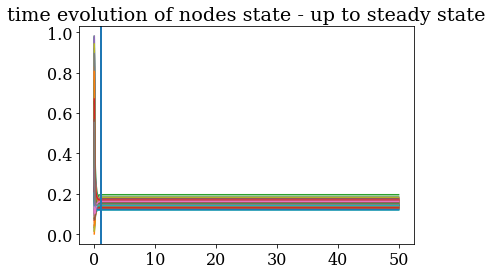

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=12.680995314630216
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Mutualistic
[1, 1, 1]


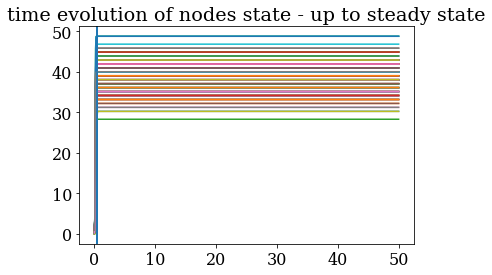

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=48.785269001404856
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 1, 1]


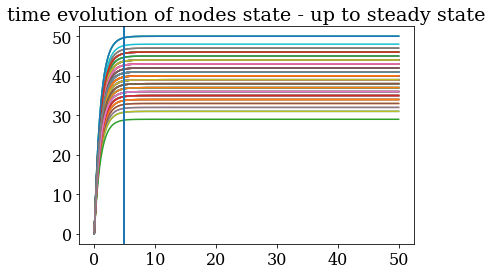

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=1.0000000000000013
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Synchronization
[0, 1]


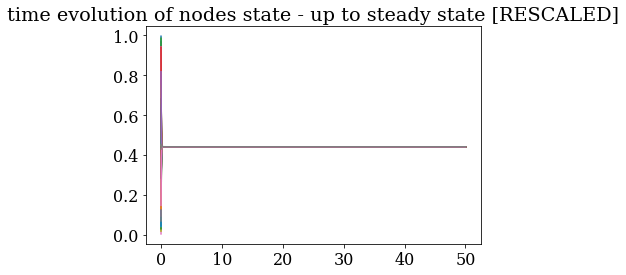

[0, 1]
Normalizing jacobian - $\lambda_{max}$=52.840708673746875
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Regulatory
[1, 1, 1, 1]


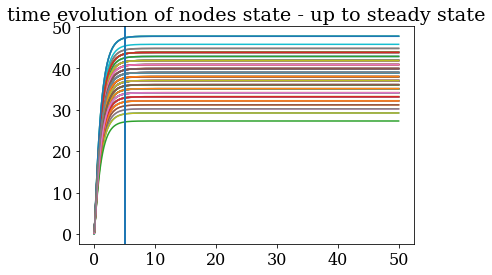

[1, 1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=1.0065576584147802
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Regulatory
[1, 1, 2, 1]


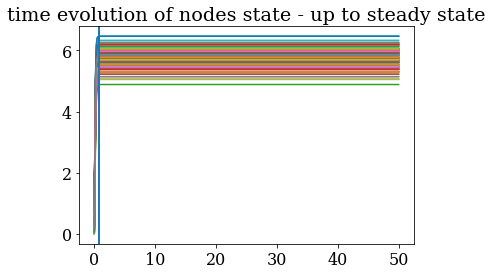

[1, 1, 2, 1]
Normalizing jacobian - $\lambda_{max}$=12.946313782003209
- Compute average distance...



- Compute hierarchical clustering with method ward...


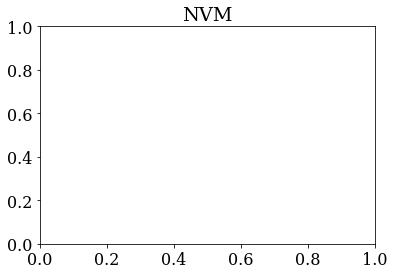

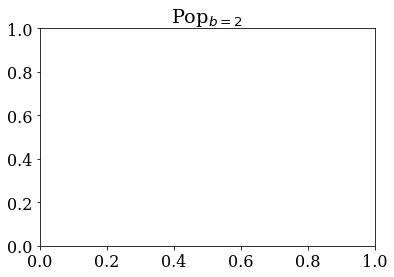

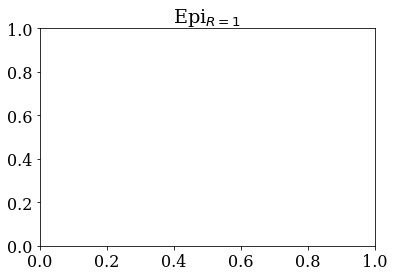

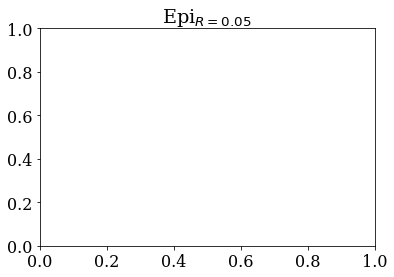

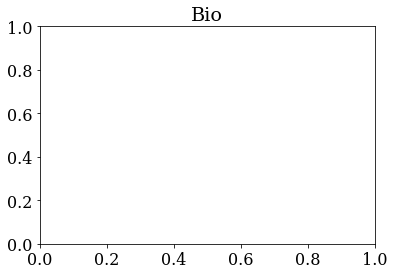

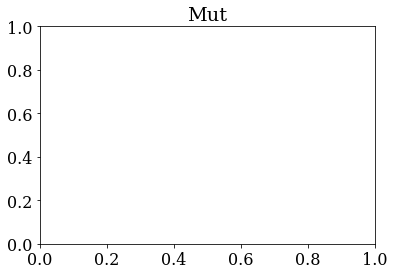

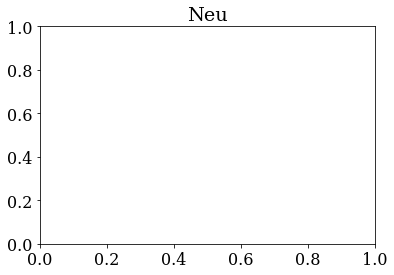

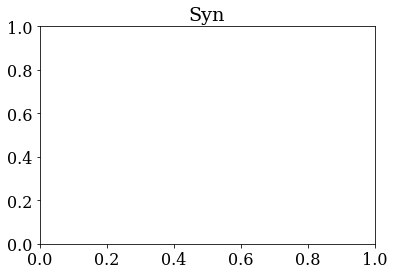

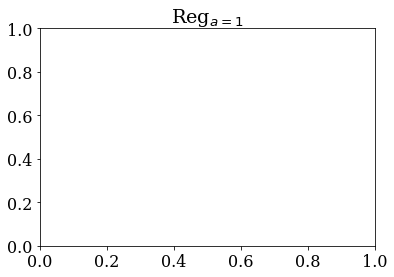

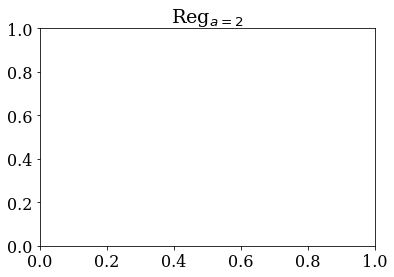

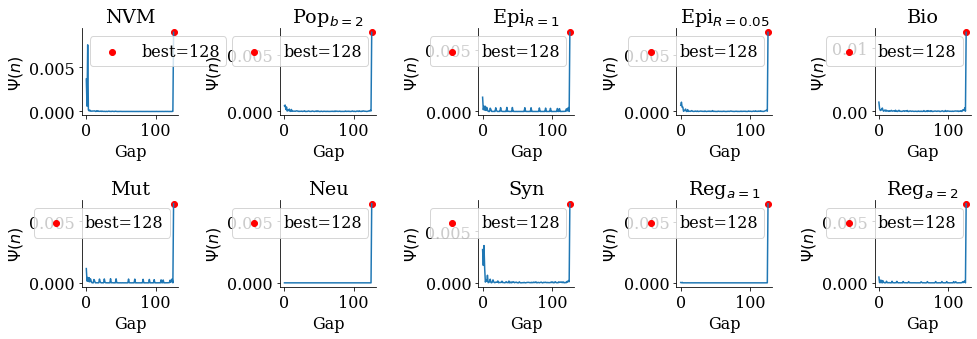

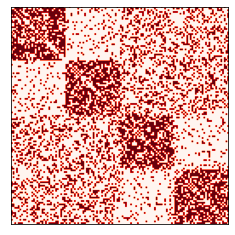

JACOBIAN DISTANCE
Dynamics: NoisyVM
[1, 1]


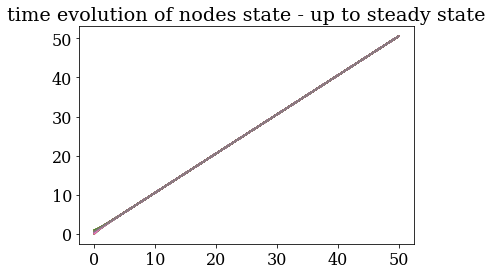

[1, 1]
Normalizing jacobian - $\lambda_{max}$=1.237551081657823
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Population
[1, 1, 2, 1]


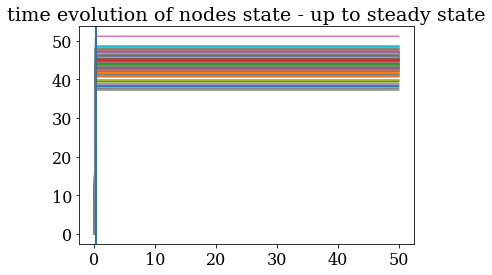

[1, 1, 2, 1]
Normalizing jacobian - $\lambda_{max}$=105.28359734395536
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 1]


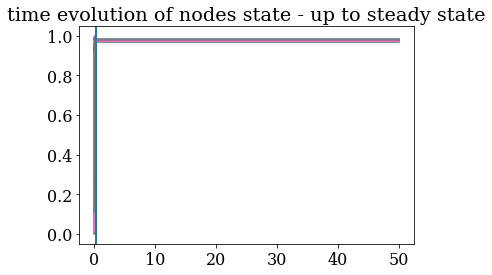

[1, 1]
Normalizing jacobian - $\lambda_{max}$=58.645976937496606
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.05]


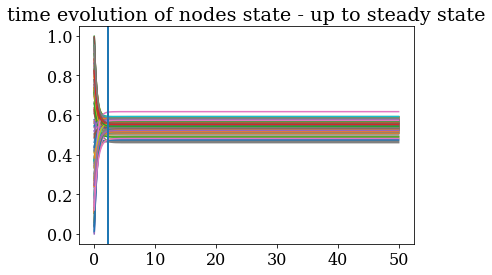

[1, 0.05]
Normalizing jacobian - $\lambda_{max}$=2.658427313810197
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Biochemical
[1, 1, 1]


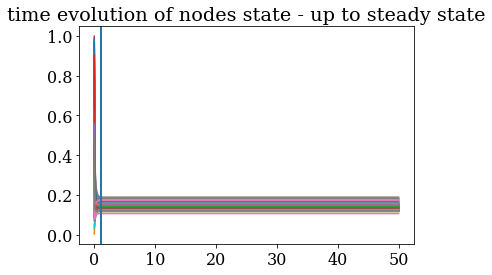

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=13.479084541585836
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Mutualistic
[1, 1, 1]


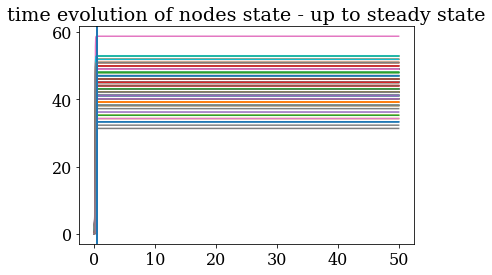

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=58.677480159379066
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Neuronal
[1, 1, 1]


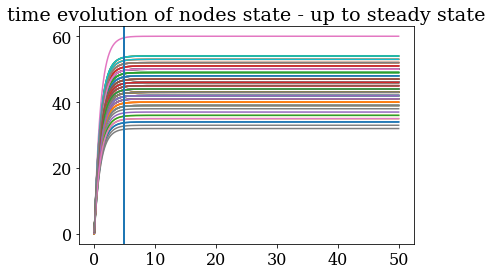

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=1.000000000000001
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Synchronization
[0, 1]


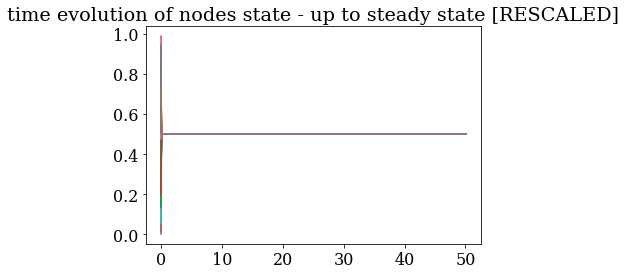

[0, 1]
Normalizing jacobian - $\lambda_{max}$=61.81753201175749
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Regulatory
[1, 1, 1, 1]


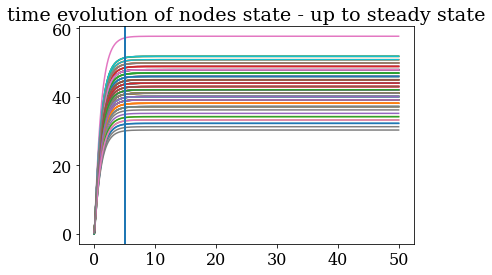

[1, 1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=1.0056305064919058
- Compute average distance...



- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Regulatory
[1, 1, 2, 1]


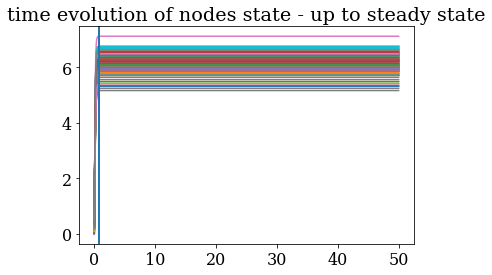

[1, 1, 2, 1]
Normalizing jacobian - $\lambda_{max}$=14.25381245332833
- Compute average distance...



- Compute hierarchical clustering with method ward...


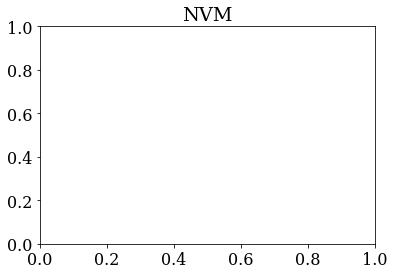

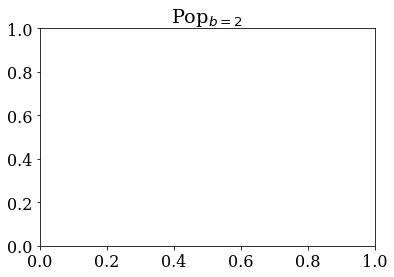

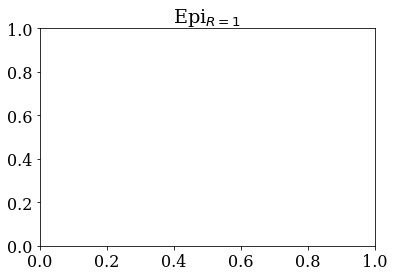

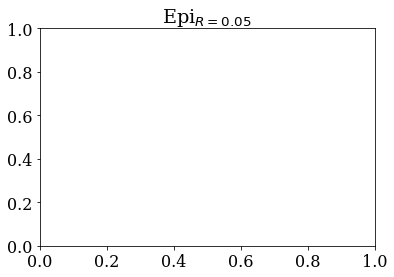

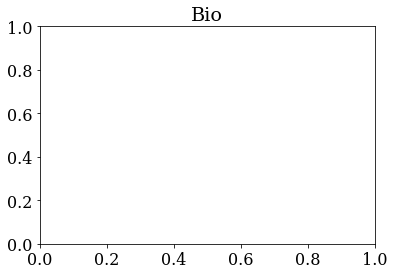

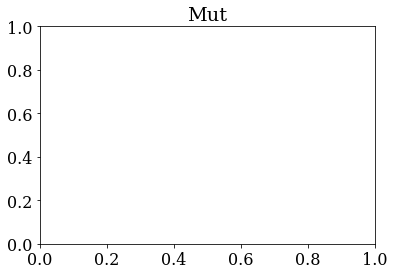

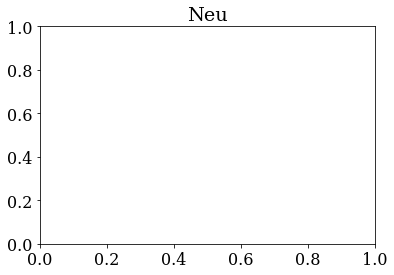

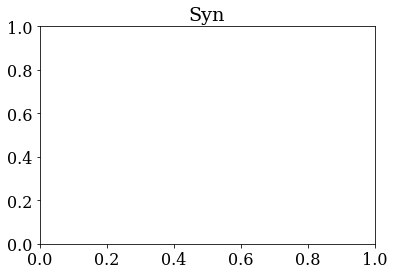

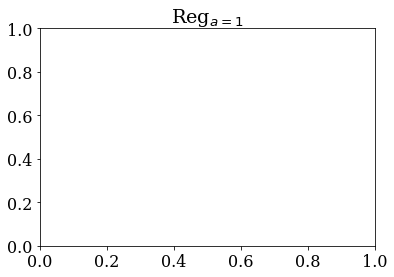

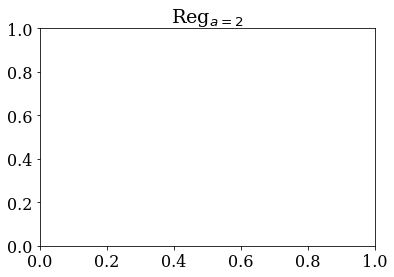

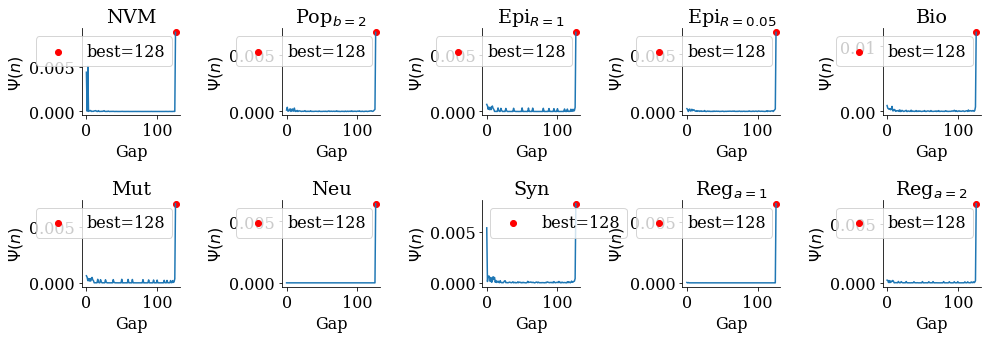

In [471]:
for k in ks:
    ### Create matrix
    HMshape = [2,2,32]
    avklist = [k,4,20]

    adj = HM.HMRandomGraph(HMshape, avklist)

    plt.imshow(adj, cmap='Reds')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    ### Compute distance
    ress = []

    for i, dynamic in enumerate(dynamics):
        res = distance.jacobian_distance(adj, dynamic, norm=True, args=params[i], name='fig3', title=None, comms=None, show=False)
        ress.append(res)
        
    ### Compute deltas
    to_plot = False

    deltas_all = []

    for idx, res in enumerate(ress):
        # Compute linkage
        mylinkage = linkage(squareform(res[0]), method='ward')
        # Create dendrogram
        dn = dendrogram(mylinkage, no_plot=not to_plot)
        plt.title(labels_short[idx])
        plt.show()
        # Get heights
        heights = np.array( [tmp[1] for tmp in dn['dcoord']] )
        heights = np.sort(heights)[::-1]
        deltas = heights[:-1] - heights[1:]
        #deltas = deltas / deltas[0]
        deltas = np.concatenate([deltas, [heights[-1]]])
    
        deltas_all.append(deltas)
        
    ### Plot partition stability
    plt.figure(figsize=(14,5))

    n_rows = 2
    n_cols = 5

    for idx, dynamic in enumerate(labels_short):
        plt.subplot(n_rows,n_cols, idx+1)
    
        plt.plot(deltas_all[idx])
        #plt.plot(np.log(heights_all[idx][:-1]) - np.log(heights_all[idx][1:]))
        plt.title(dynamic)
        plt.xlabel('Gap')
        plt.ylabel(r'$\Psi(n)$')
    
        best_gap = np.argmax(deltas_all[idx])
        plt.scatter(best_gap, np.max(deltas_all[idx]), c='r', label='best='+str(best_gap+2))
        plt.legend()
    
    sns.despine()
    plt.tight_layout()
    plt.show()

# Try with social network

In [22]:
def load_network(name, return_pos=False):
    folder = f'./data/{name}/'
    nodes = pd.read_csv(folder+'nodes.csv')
    edges = pd.read_csv(folder+'edges.csv')
    
    N = len(nodes)
    mat = np.zeros((N,N))

    vin = edges['# source'].values
    vout = edges[' target'].values

    for i in range(len(vin)):    
        mat[vin[i], vout[i]] = 1
    
    # Remove diagonal
    mat = mat + mat.T - 2*np.diag(np.diag(mat))
    # Remove parallel links
    mat[mat>1] = 1
    
    if return_pos:
        pos = nodes[' _pos'].values
        pos = [tmp.split('[')[1] for tmp in pos]
        pos = [tmp.split(']')[0] for tmp in pos]
        pos = [tmp.split(',') for tmp in pos]
        pos = np.array(pos).astype(float)
        return mat, pos
    else:
        return mat

In [23]:
def plot_results(avg_dd, cmap='Spectral_r', method='ward', name=None, comms=None, row_colors=None, title=None, figsize=(18,8)):
    N = len(avg_dd)
    
    ### Plot clustermap
    # Create linkage
    mylinkage = linkage(squareform(avg_dd), method=method)
    
    # Setup row colors
    if row_colors is None and comms is not None:
        #labels = np.repeat(np.arange(n_comms),N//n_comms)
        #row_colors = [palette[i] for i in labels]
        n_comms = len(np.unique(comms))
        palette = hls_palette(n_comms)
        row_colors = [palette[i] for i in comms]
    
    # Create clustermap
    clust_map = clustermap(avg_dd, row_linkage=mylinkage, col_linkage=mylinkage,
                           cmap=cmap,
                           #cbar_kws = dict(orientation='horizontal'),
                           cbar_pos=None,
                           row_colors=row_colors,
                           tree_kws=dict(linewidths=1.),
                           figsize=figsize, dendrogram_ratio=0.15, #0.15
                           xticklabels=False, yticklabels=False)

    clust_map.ax_col_dendrogram.set_visible(False) # hide dendrogram above columns
    
    # Update position
    clust_map.gs.update(left=0.5)
    
    # Setup colorbar
    cbnorm = Normalize(vmin=np.min(avg_dd),vmax=np.max(avg_dd)) #setting the scale
    cb = plt.colorbar(cm.ScalarMappable(norm=cbnorm, cmap=cmap),ax=clust_map.ax_heatmap,pad=0.01) #0.08
    #cb.ax.set_title(r'$\overline{d}_{ij}$')
    cb.ax.tick_params(labelsize=20)
    tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator
    cb.update_ticks()
    
    plt.tight_layout()
    if title is not None:
        plt.title(title, size=40)
    
    if name is not None:
        plt.savefig(name, bbox_inches='tight', pad_inches=0.1)
    
    plt.show()

In [24]:
social, pos = load_network('social', return_pos=True)

G = nx.from_numpy_array(social)
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
print(nx.is_connected(G0))

social = nx.to_numpy_array(G0)

node_ok = np.array(list(G0.nodes))
pos = pos[node_ok]

True


In [25]:
Rs = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
params = [[1, R] for R in Rs]

labels_short = [f'Epi, R={tmp[1]}' for tmp in params]
labels_short = ['Diff'] + labels_short
labels_short

['Diff',
 'Epi, R=1',
 'Epi, R=0.9',
 'Epi, R=0.8',
 'Epi, R=0.7',
 'Epi, R=0.6',
 'Epi, R=0.5',
 'Epi, R=0.4']

DIFFUSION DISTANCE
- Compute laplacian...
1.0 1.0
- Compute average distance...


  0%|          | 0/141 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 1]


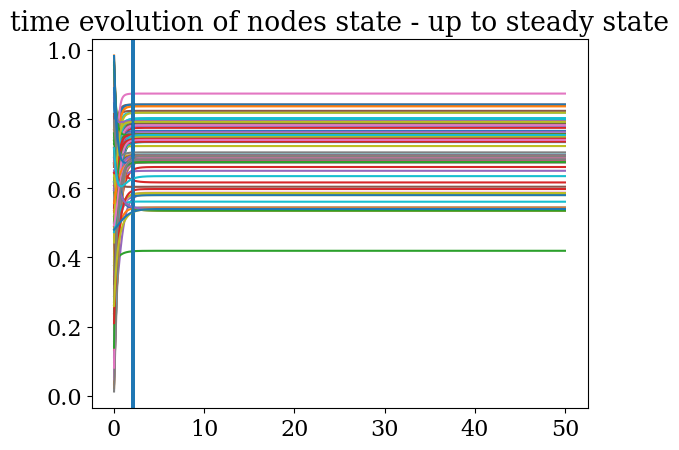

[1, 1]
Normalizing jacobian - $\lambda_{max}$=8.024663551591111
- Compute average distance...


  0%|          | 0/141 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.9]


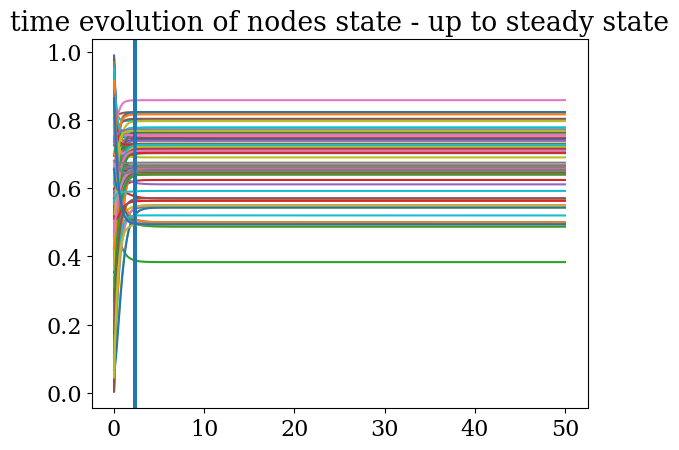

[1, 0.9]
Normalizing jacobian - $\lambda_{max}$=7.139563329067178
- Compute average distance...


  0%|          | 0/141 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.8]


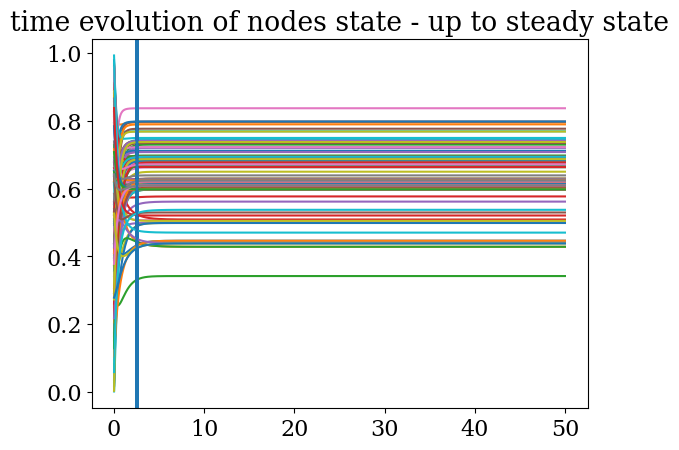

[1, 0.8]
Normalizing jacobian - $\lambda_{max}$=6.259386817234319
- Compute average distance...


  0%|          | 0/141 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.7]


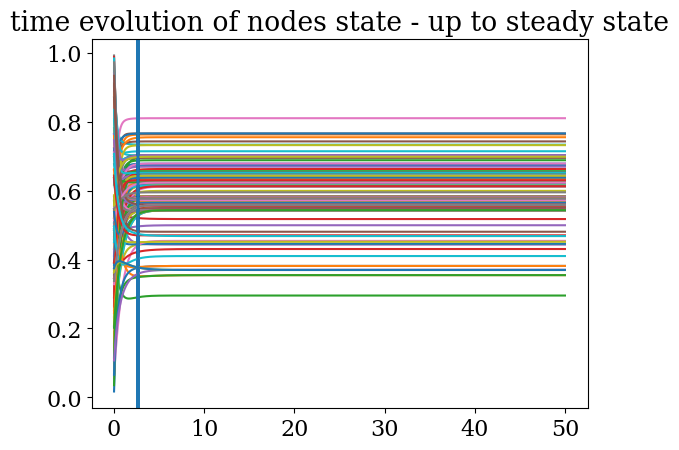

[1, 0.7]
Normalizing jacobian - $\lambda_{max}$=5.386916871197849
- Compute average distance...


  0%|          | 0/141 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.6]


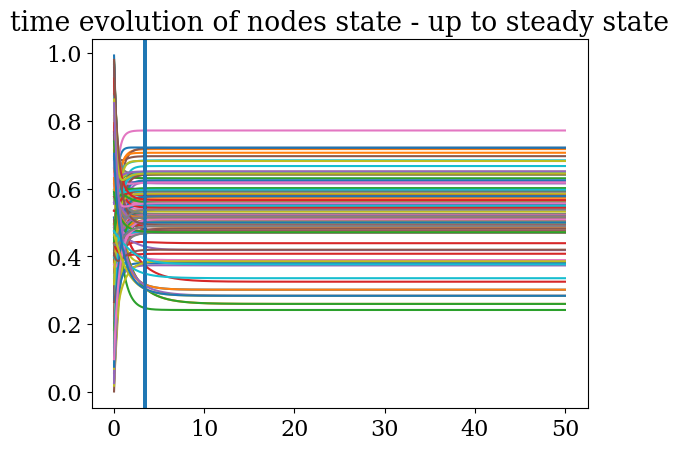

[1, 0.6]
Normalizing jacobian - $\lambda_{max}$=4.527339369317774
- Compute average distance...


  0%|          | 0/141 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.5]


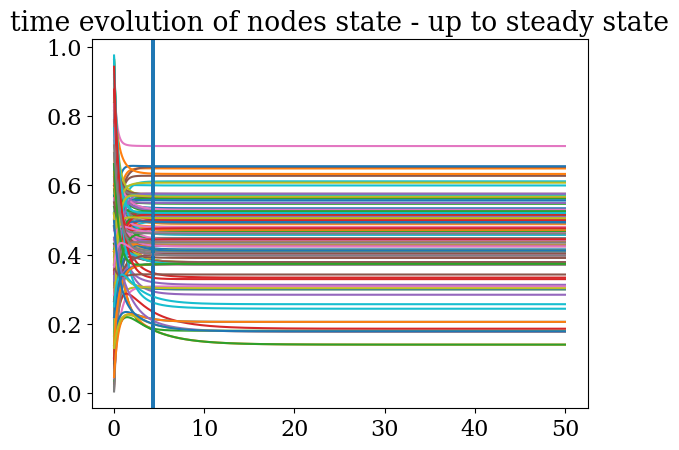

[1, 0.5]
Normalizing jacobian - $\lambda_{max}$=3.6910931085194036
- Compute average distance...


  0%|          | 0/141 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.4]


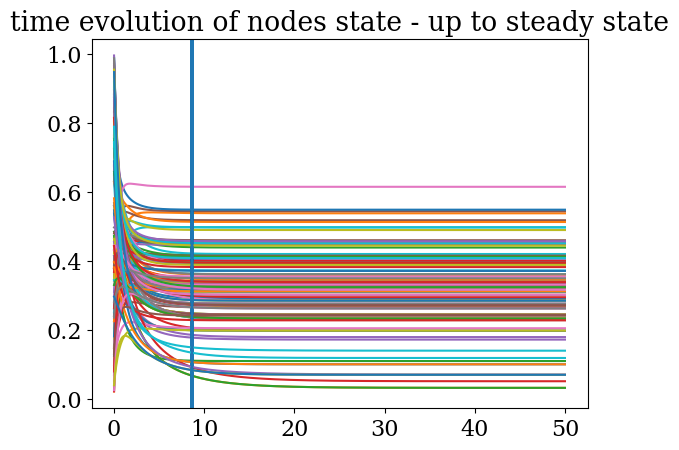

[1, 0.4]
Normalizing jacobian - $\lambda_{max}$=2.900164840653459
- Compute average distance...


  0%|          | 0/141 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...


In [26]:
ress_social = []

to_show = False

### Diffusion
res = distance.diffusion_distance(social, name='goodness_social', title=None, comms=None, show=to_show)
ress_social.append(res)

### Jacobian
for param in params:
    res = distance.jacobian_distance(social, 'Epidemics', norm=True, args=param, name='goodness_social', title=None, comms=None, show=to_show)
    ress_social.append(res)

In [27]:
to_plot = False

deltas_all = []

for idx, res in enumerate(ress_social):
    # Compute linkage
    mylinkage = linkage(squareform(res[0]), method='ward')
    # Create dendrogram
    dn = dendrogram(mylinkage, no_plot=not to_plot)
    
    if to_plot:
        plt.title(labels_short[idx])
        plt.show()
        
    # Get heights
    heights = np.array( [tmp[1] for tmp in dn['dcoord']] )
    heights = np.sort(heights)[::-1]
    deltas = heights[:-1] - heights[1:]
    #deltas = deltas / deltas[0]
    deltas = np.concatenate([deltas, [heights[-1]]])
    
    deltas_all.append(deltas)

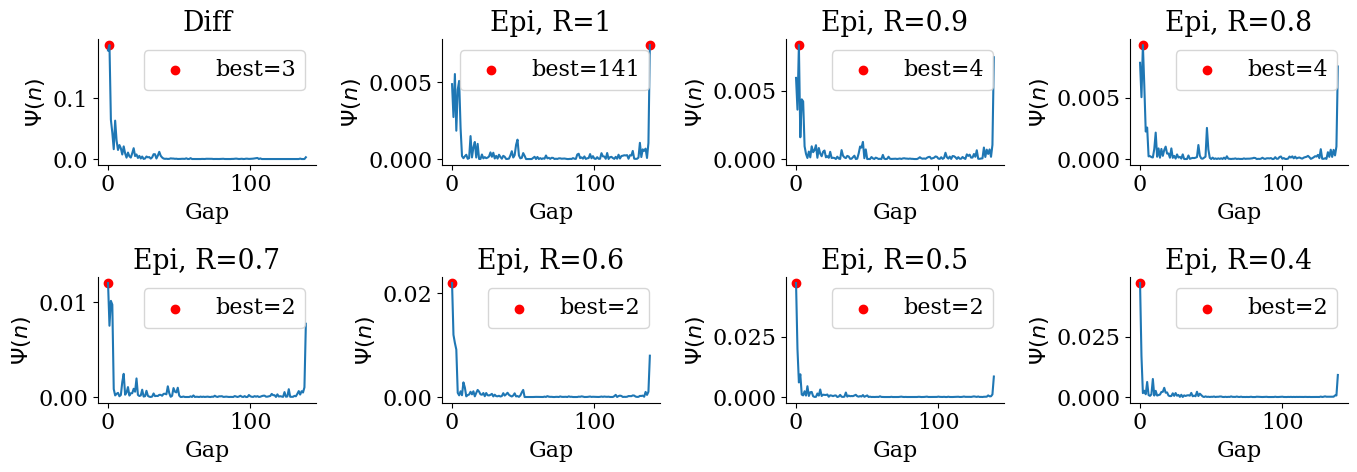

In [34]:
plt.figure(figsize=(14,5))

n_rows = 2
n_cols = 4

best_comms = []

for idx, dynamic in enumerate(labels_short):
    plt.subplot(n_rows,n_cols, idx+1)
    
    plt.plot(deltas_all[idx])
    #plt.plot(np.log(heights_all[idx][:-1]) - np.log(heights_all[idx][1:]))
    plt.title(dynamic)
    plt.xlabel('Gap')
    plt.ylabel(r'$\Psi(n)$')
    
    best_gap = np.argmax(deltas_all[idx])
    best_comms.append(best_gap+2)
    
    plt.scatter(best_gap, np.max(deltas_all[idx]), c='r', label='best='+str(best_gap+2))
    plt.legend()
    
sns.despine()
plt.tight_layout()
plt.show()

In [35]:
params

[[1, 1], [1, 0.9], [1, 0.8], [1, 0.7], [1, 0.6], [1, 0.5], [1, 0.4]]

In [39]:
tmp_params = ['Diff'] + params
titles = [f'Epidemics, R={R}' for R in Rs]
titles = ['Diffusion'] + titles
titles = [titles[i] + f' - Ncomms={best_comms[i]}' for i in range(len(titles))]
titles

['Diffusion - Ncomms=3',
 'Epidemics, R=1 - Ncomms=141',
 'Epidemics, R=0.9 - Ncomms=4',
 'Epidemics, R=0.8 - Ncomms=4',
 'Epidemics, R=0.7 - Ncomms=2',
 'Epidemics, R=0.6 - Ncomms=2',
 'Epidemics, R=0.5 - Ncomms=2',
 'Epidemics, R=0.4 - Ncomms=2']

/tmp/ipykernel_118825/1606663562.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


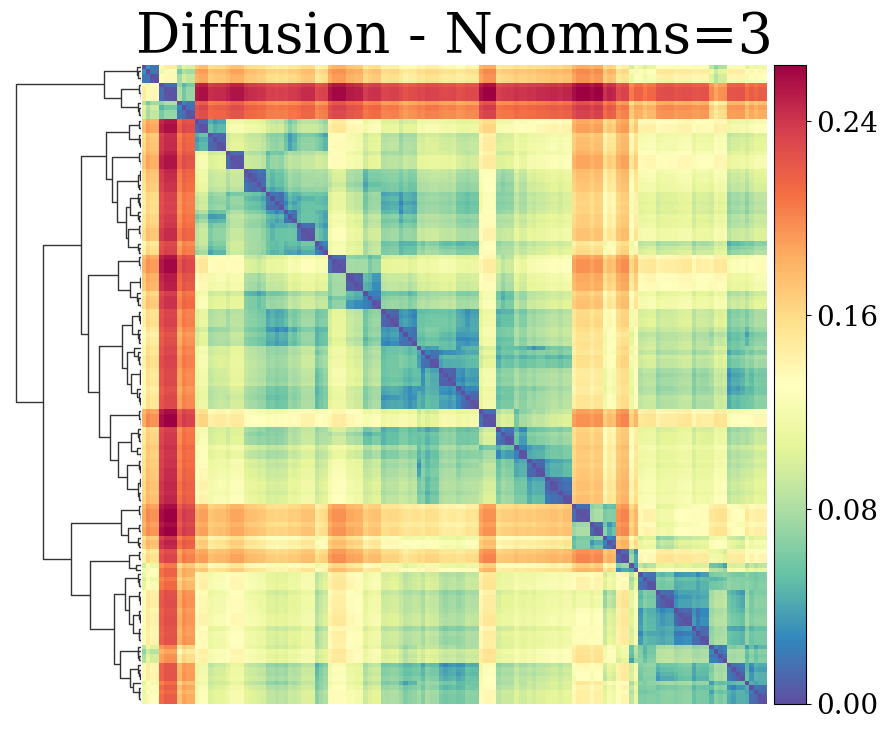

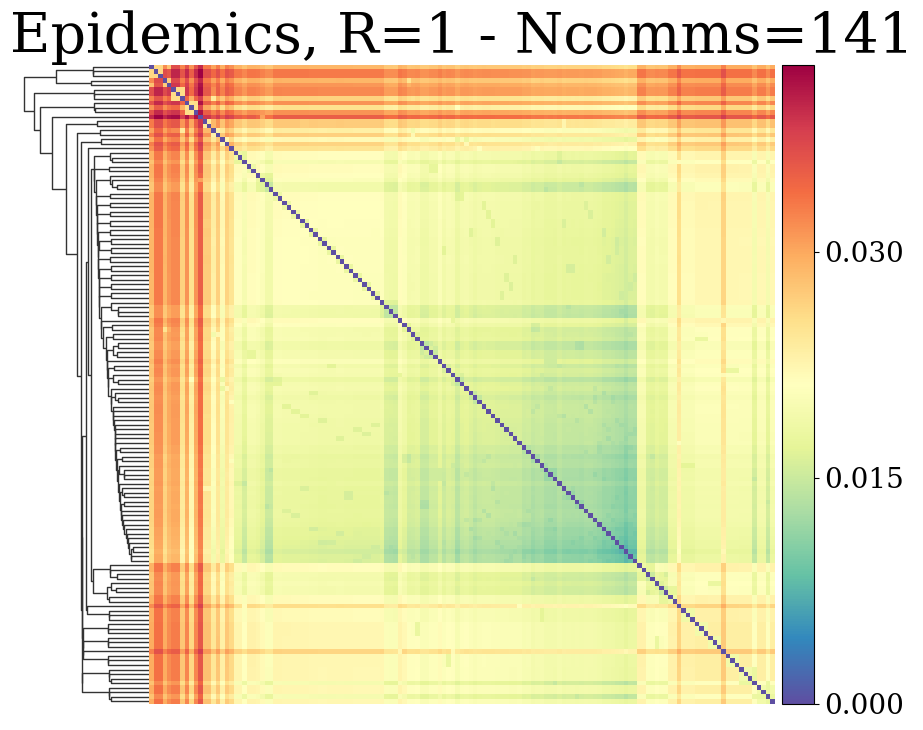

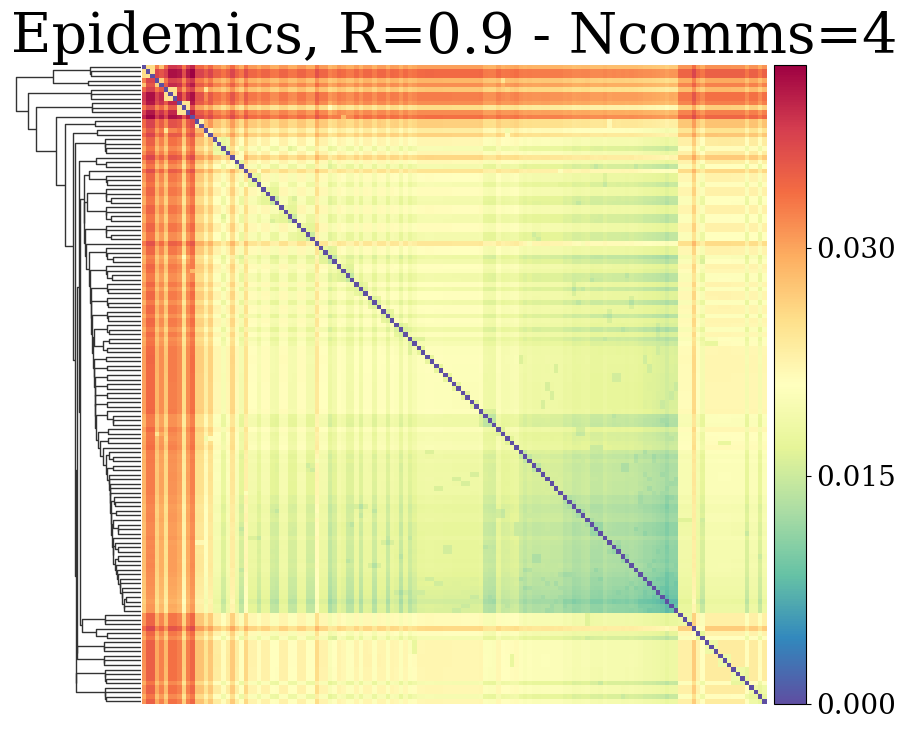

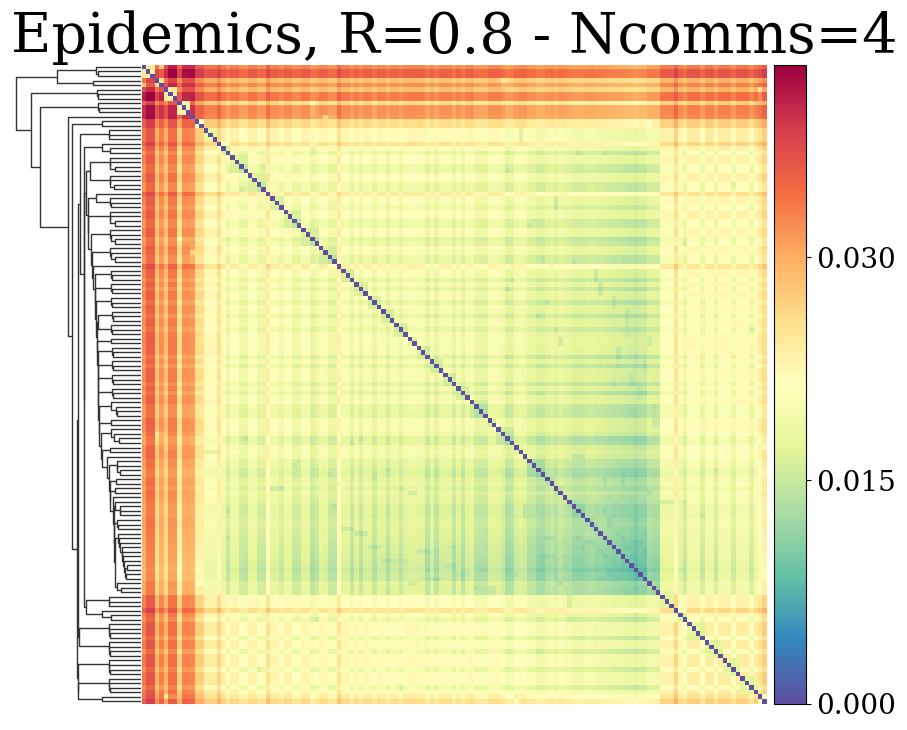

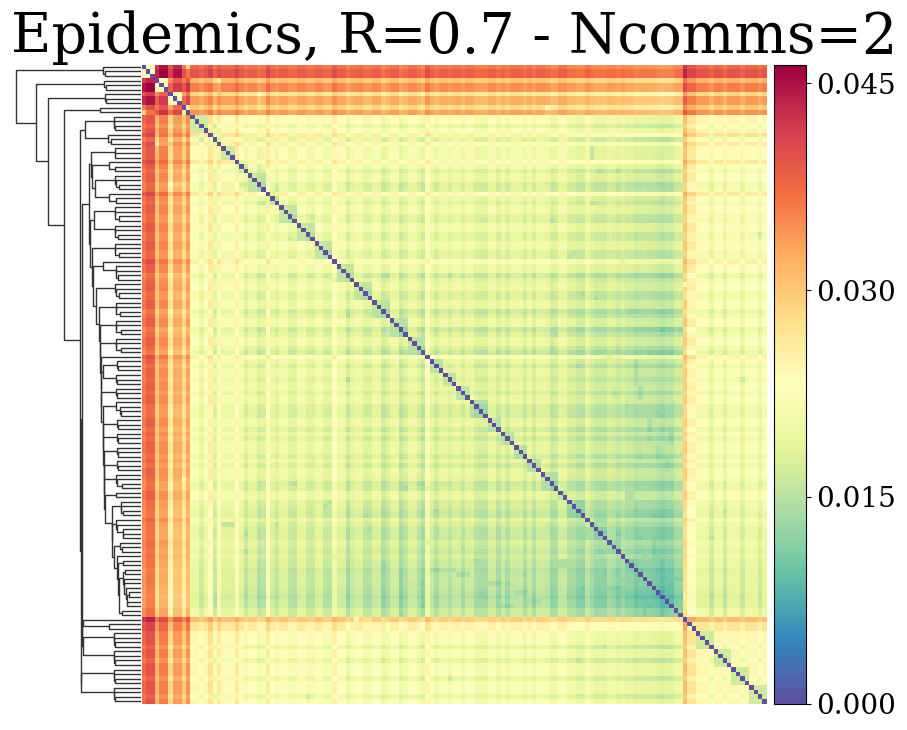

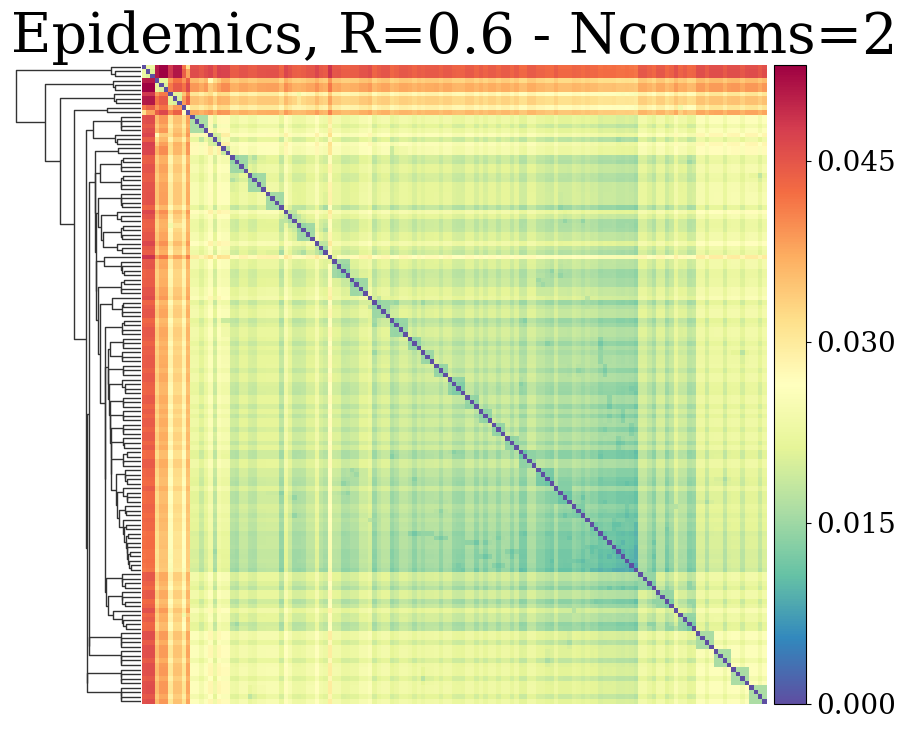

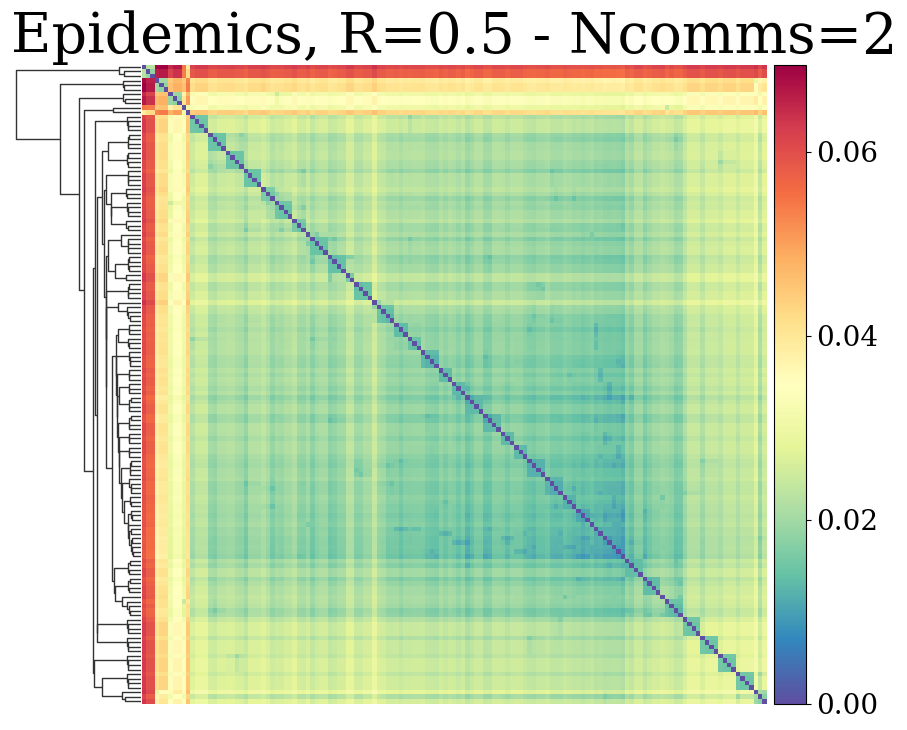

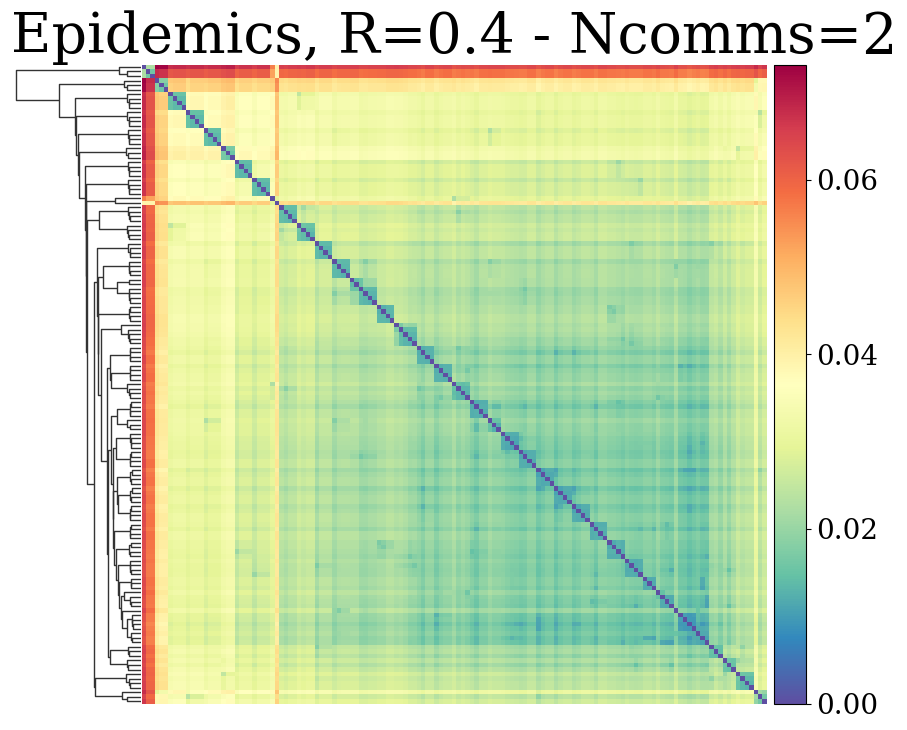

In [41]:
for i, param in enumerate(tmp_params):
    ### Load data
    if param=='Diff':
        fname = 'results/diffusion_goodness_social.txt'
    else:
        fname = 'results/Epidemics_'+str(param)+'_goodness_social.txt'
    tmp = np.loadtxt(fname)
    
    ### Plot
    plot_results(tmp, name=f'figures/figure_goodness_social_{i+1}.png', title=titles[i])